# Import

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from IPython.display import Audio

# Datensatz

In [3]:
path_data = r"data/audioMNIST/01/"
audio_files = os.listdir(path_data)

Importiere Ordner 1 bis 20 

In [4]:
base_path = "data/audioMNIST/"
directories = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]
audio_files = []
sample_rate = 48000

for directory in directories:
    directory_path = os.path.join(base_path, directory)
    for file in os.listdir(directory_path):
        if file.endswith('.wav'):
            full_path = os.path.join(directory_path, file)
            audio_files.append(full_path)

# Überprüfen der kombinierten Liste
print(f"Anzahl der Audiodateien: {len(audio_files)}")


Anzahl der Audiodateien: 10000


Speicher Ziffern

In [523]:
# Liste für die extrahierten Zahlen
extracted_numbers = []

for file in audio_files:
    # Trenne den Dateinamen an den Unterstrichen
    parts = file.split('_')
    # Extrahiere die erste Zahl (als String) und konvertiere sie in ein Integer
    number = int(parts[0].split('/')[-1])
    # Füge die Zahl zur Liste hininzu
    extracted_numbers.append(number)


Speicher Personen

In [524]:
# Liste für die extrahierten Stimmen
extracted_voices = []

for file in audio_files:
    # Trenne den Dateinamen an den Unterstrichen
    parts = file.split('_')
    # Extrahiere die zweite Zahl (als String) und konvertiere sie in ein Integer
    voice = int(parts[1])
    # Füge die Stimme zur Liste hinzu
    extracted_voices.append(voice)



Funktion zur Extrahierung der Audioeigenschaften

In [6]:
# Funktion zum Laden von Audiodateien und Extrahieren von MFCCs
def load_and_extract_features(filename):
    audio, sample_rate = librosa.load(filename, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate)
    return mfccs

## Audio MNIST Distanzsmatrix

Hier werden die Merkmale extrahiert um eine Ähnlichkeitsmatrix zu erstellen

In [7]:
# Erster Durchlauf: Berechnen von MFCCs und Ermitteln der maximalen Länge
audio_features = []
max_length = 0
for full_path in audio_files:
    mfccs = load_and_extract_features(full_path)
    max_length = max(max_length, mfccs.shape[1])
    audio_features.append(mfccs)

# Zweiter Durchlauf: MFCCs auf die maximale Länge auffüllen
padded_audio_features = []
for mfccs in audio_features:
    pad_width = max_length - mfccs.shape[1]
    padded_mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    padded_audio_features.append(padded_mfccs.flatten())  # Flatten the arrays

# In ein numpy-Array für die Distanzberechnung umwandeln
padded_audio_features = np.array(padded_audio_features)

# Paarweise Distanzen zwischen den Audiosamples berechnen
distances = cdist(padded_audio_features, padded_audio_features, metric='euclidean')

# distances[i][j] wird nun die Distanz zwischen Audiodatei i und j enthalten

/var/folders/mz/kyq6j6vd6994vn2xvgws6w1w0000gn/T/ipykernel_1311/1860554620.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', 10)


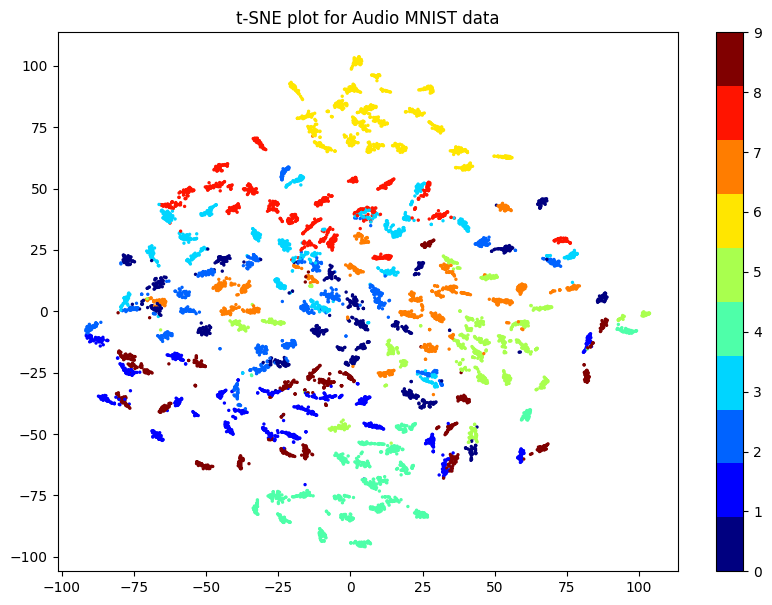

In [328]:
# Merkmalsextraktion
features = []
for full_path in audio_files:
    y, sr = librosa.load(full_path, sr=sample_rate)
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    mfccs_mean = np.mean(mfccs, axis=1)
    features.append(mfccs_mean)

# t-SNE
features_tsne = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(np.array(features))

# Erstelle den Plot
plt.figure(figsize=(10, 8))
cmap = plt.cm.get_cmap('jet', 10)
sc = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], s=2, c=extracted_numbers, cmap=cmap)
plt.colorbar(sc, ticks=range(10))
plt.title('t-SNE plot for Audio MNIST data')
plt.show()

/var/folders/mz/kyq6j6vd6994vn2xvgws6w1w0000gn/T/ipykernel_1311/26273821.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', 20)


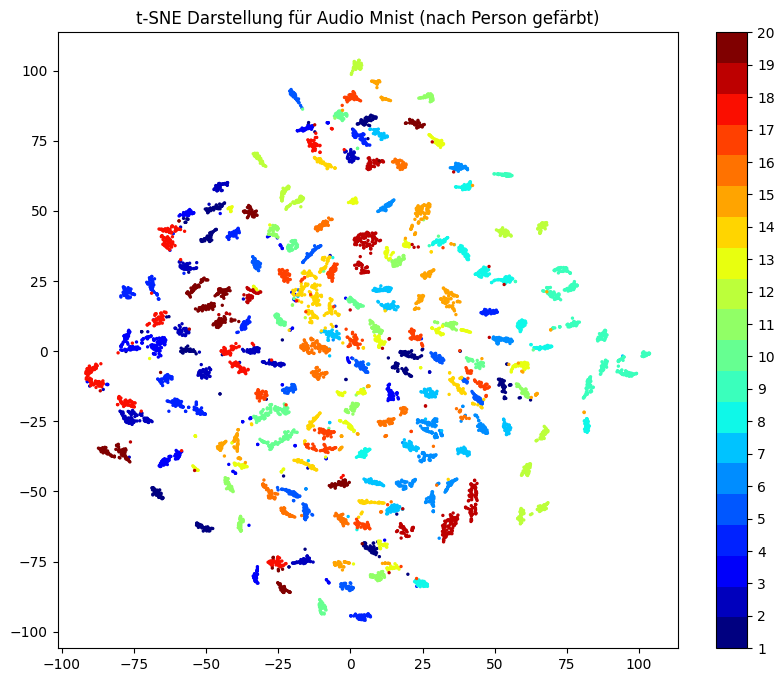

In [365]:
# Erstelle den Plot
plt.figure(figsize=(10, 8))
cmap = plt.cm.get_cmap('jet', 20)
sc = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], s=2, c=extracted_voices, cmap=cmap)
plt.colorbar(sc, ticks=range(21))
plt.title('t-SNE Darstellung für Audio Mnist (nach Person gefärbt)')
plt.show()

# Nächste-Nachbarn-Methode

In [9]:
scores = distances

In [10]:
# Grenzwert n_neighbours
n_neighbours = 200

# Sortiere die Scores und nimm die ersten n_neighbours Werte
sorted_scores = [sorted(score_array)[:n_neighbours] for score_array in scores]

# Berechne die Summe der Werte und die Anzahl der Instanzen in jedem Array
value_sums = [sum(score_array) for score_array in sorted_scores]
instance_counts = [len(score_array) for score_array in sorted_scores]

# Berechne den Durchschnitt für jedes Array
averages = [value_sum / instance_count for value_sum, instance_count in zip(value_sums, instance_counts)]

# Sortiere die Indizes nach den Durchschnittswerten
sorted_indices = sorted(range(len(averages)), key=lambda i: averages[i], reverse=True)

# Zeige die Top 5
top_5_indices = sorted_indices[:5]
print("Top 5:")
for i in top_5_indices:
    print('Mittelwert:', averages[i], ' Index:', i)
    display(Audio(filename=audio_files[i], rate=sample_rate))

# Zeige die letzten 5 Werte
last_5_indices = sorted_indices[-5:]
print("\nLetzte 5:")
for i in last_5_indices:
    print('Mittelwert:', averages[i], ' Index:', i)
    display(Audio(filename=audio_files[i], rate=sample_rate))


Top 5:
Mittelwert: 3000.6319954212418  Index: 8931


Mittelwert: 2936.0932835010694  Index: 4438


Mittelwert: 2931.397316459459  Index: 9282


Mittelwert: 2901.0556710249143  Index: 5122


Mittelwert: 2888.47428075693  Index: 8850



Letzte 5:
Mittelwert: 673.0649534209628  Index: 6535


Mittelwert: 672.6224583092647  Index: 7722


Mittelwert: 663.6195304813914  Index: 2391


Mittelwert: 663.4897043697603  Index: 1275


Mittelwert: 655.7062496243578  Index: 3499


In [11]:
# Normalisierung und Umkehrung
rarityScore = averages
min_score = min(rarityScore)
max_score = max(rarityScore)
rarityScore = (rarityScore - min_score) / (max_score - min_score)

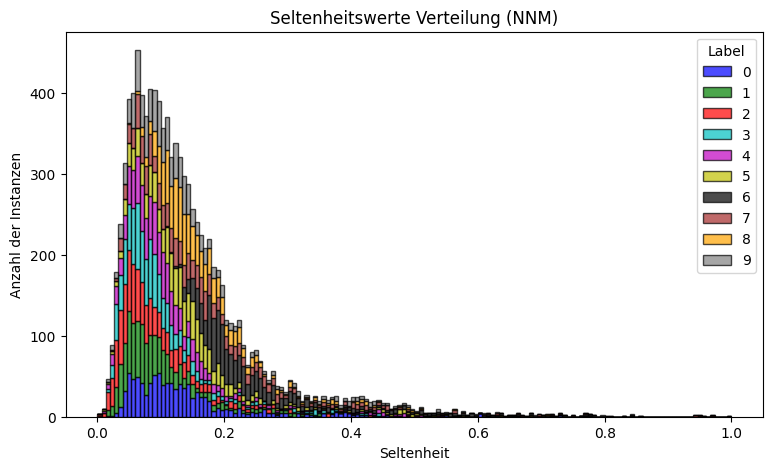

In [333]:
# Plotte Rarity Scores zwischen 0.5 und 1 aller Ziffern mit Label

plt.figure(figsize=(9, 5))
plt.title('Seltenheitswerte Verteilung (NNM)')

# Liste mit Farben für die Labels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange', 'gray']

# Labels definieren
labels = np.array(extracted_numbers, dtype=int)

# Erstelle  Histogramm
plt.hist([rarityScore[labels == i] for i in range(10)], range=[0, 1],  bins=150, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(10)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Label')
plt.show()

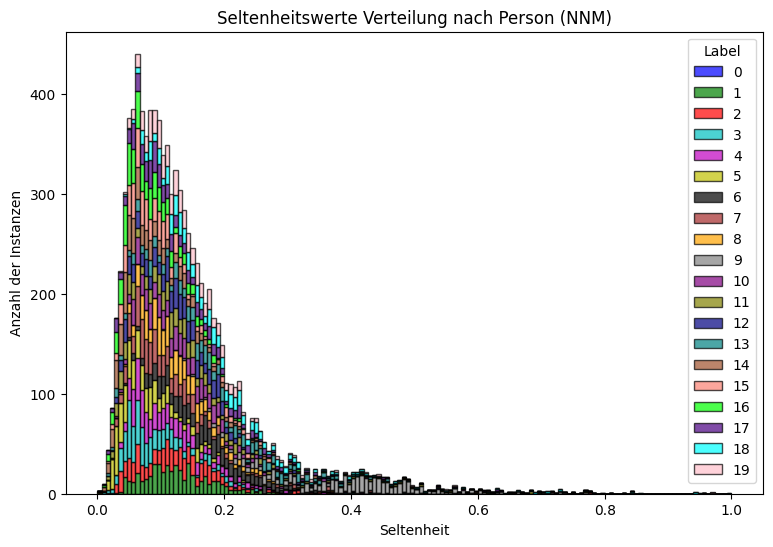

In [359]:
# Plotte Rarity Scores zwischen 0.5 und 1 aller Ziffern mit Label

plt.figure(figsize=(9, 6))
plt.title('Seltenheitswerte Verteilung nach Person (NNM)')

# Liste mit Farben für die Labels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange', 'gray', 'purple', 'olive', 'navy', 'teal', 'sienna', 'salmon', 'lime', 'indigo', 'cyan', 'pink']

# Labels definieren
labels = np.array(extracted_voices, dtype=int)

# Erstelle  Histogramm
plt.hist([rarityScore[labels == i] for i in range(20)], range=[0, 1],  bins=150, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(20)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Person')
plt.show()

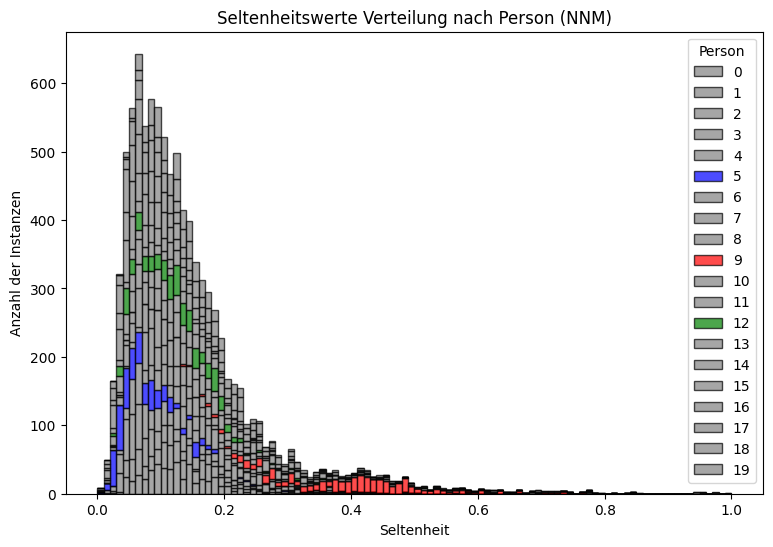

In [511]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9, 6))
plt.title('Seltenheitswerte Verteilung nach Person (NNM)')

# Liste mit Farben für die Labels
colors = ['gray'] * 20  # Alle Labels zunächst auf Grau setzen
highlighted_labels = [5, 9, 12]  # Personen, die hervorgehoben werden sollen
highlight_colors = ['b', 'r', 'g']  # Farben für die hervorgehobenen Personen

# Farben für hervorgehobene Personen festlegen
for i, label in enumerate(highlighted_labels):
    colors[label] = highlight_colors[i]

# Labels definieren
labels = np.array(extracted_voices, dtype=int)

# Erstelle Histogramm
plt.hist([rarityScore[labels == i] for i in range(20)], range=[0, 1], bins=100, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(20)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Person')
plt.show()


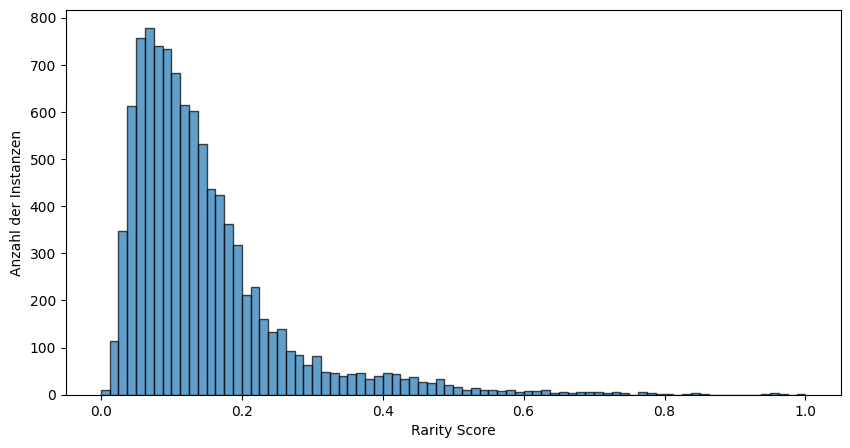

In [12]:
# Erstelle  Histogramm der Ähnlichkeitsverteilungen
plt.figure(figsize=(10, 5))
plt.hist(rarityScore, bins=80, edgecolor='black', alpha=0.7, range=[0,1])

plt.xlabel('Rarity Score')
plt.ylabel('Anzahl der Instanzen')
plt.show()

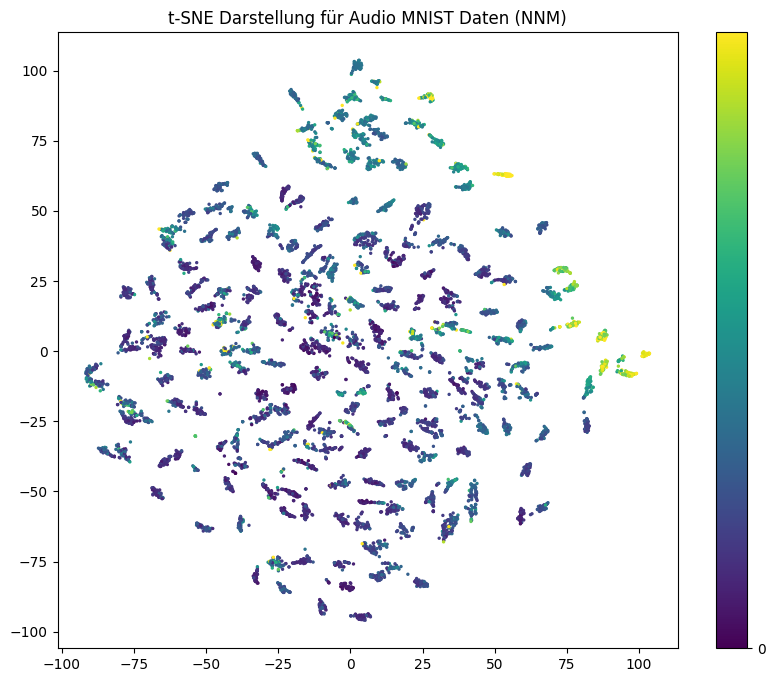

In [339]:
# Erstelle den Plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], s=2, c=rarityScore, cmap='viridis', vmax=0.5)
plt.colorbar(sc, ticks=range(10))
plt.title('t-SNE Darstellung für Audio MNIST Daten (NNM)')
plt.show()

# Flow Methode

In [14]:
scores_normalized = (scores - scores.min()) / (scores.max() - scores.min())

In [15]:
scores_normalized

array([[0.        , 0.48355389, 0.38080887, ..., 0.37436307, 0.4053681 ,
        0.55035478],
       [0.48355389, 0.        , 0.58010703, ..., 0.57753962, 0.35050196,
        0.29345252],
       [0.38080887, 0.58010703, 0.        , ..., 0.2100908 , 0.53044329,
        0.62860235],
       ...,
       [0.37436307, 0.57753962, 0.2100908 , ..., 0.        , 0.51165594,
        0.63229348],
       [0.4053681 , 0.35050196, 0.53044329, ..., 0.51165594, 0.        ,
        0.41970239],
       [0.55035478, 0.29345252, 0.62860235, ..., 0.63229348, 0.41970239,
        0.        ]])

In [17]:
def compute_flows(distance, decay=10):
    return np.exp(-decay * distance)

sorted_ids = np.argsort(scores_normalized)

n_next_hubs = 200

# Iterative Flusssuche
inward_flow_results = np.zeros(len(scores_normalized))
for id in tqdm(range(len(scores_normalized))):
    idx = sorted_ids[id][1:(n_next_hubs + 1)]
    inward_flow_results[id] += compute_flows(scores_normalized[id, idx]).sum()

100%|██████████| 10000/10000 [00:00<00:00, 101855.66it/s]


In [202]:
# Indizes der Top-5-Werte
last_5_indices_flow = np.argpartition(inward_flow_results, -5)[-5:]

# Indizes der letzten-5-Werte
top_5_indices_flow = np.argpartition(inward_flow_results, 5)[:5]

plt.figure(figsize=(20, 8))

# Zeige die Top 5 Ziffern mit der größten Ähnlichkeit zu anderen
print("Top 5:")
for j, i in enumerate(last_5_indices_flow, 1):
    print('Wert:', inward_flow_results[i], ' Index:', i)
    display(Audio(filename=audio_files[i], rate=sample_rate))

# Zeige die Top 5 Ziffern mit der kleinen Ähnlichkeit zu anderen
print("\nLetzte 5:")
for j, i in enumerate(top_5_indices_flow, 1):
    print('Wert:', inward_flow_results[i], ' Index:', i)
    display(Audio(filename=audio_files[i], rate=sample_rate))


plt.show()

Top 5:
Wert: 40.0507062100547  Index: 6809


Wert: 40.180574236072395  Index: 7647


Wert: 40.83011320995731  Index: 2391


Wert: 40.14540246241601  Index: 1275


Wert: 40.549021570196736  Index: 2118



Letzte 5:
Wert: 1.4631836426322713  Index: 4438


Wert: 1.776363325260474  Index: 8931


Wert: 1.8444409587268975  Index: 5122


Wert: 2.3187676705271754  Index: 8850


Wert: 2.0272091920845985  Index: 9282


<Figure size 2000x800 with 0 Axes>

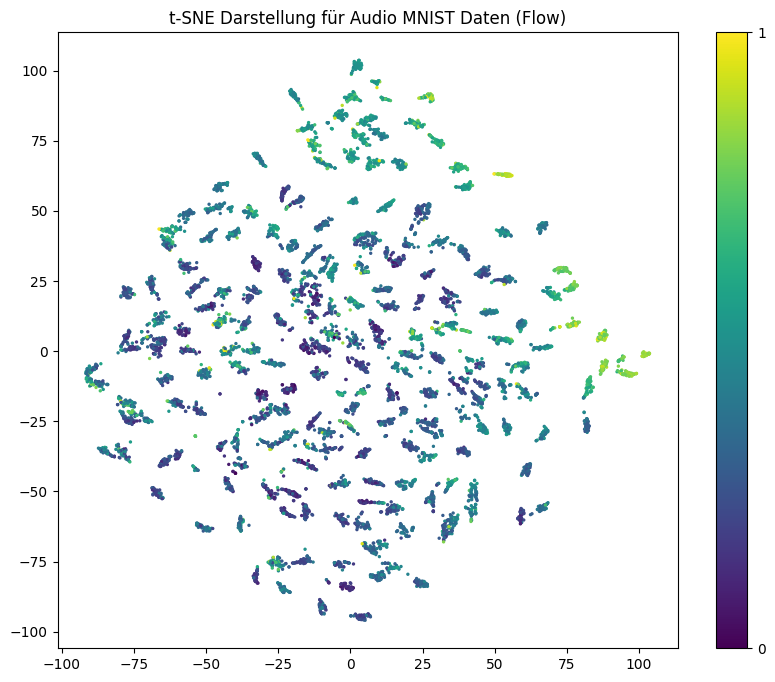

In [340]:
# Normalisierung und Umkehrung
rarityScore_flow = 1-inward_flow_results
min_score = min(rarityScore_flow)
max_score = max(rarityScore_flow)
rarityScore_flow = (rarityScore_flow - min_score) / (max_score - min_score)

# Rarity Score TSNE Plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], s=2, c=rarityScore_flow, cmap='viridis', vmax=1)
plt.colorbar(sc, ticks=range(10))
plt.title('t-SNE Darstellung für Audio MNIST Daten (Flow)')
plt.show()

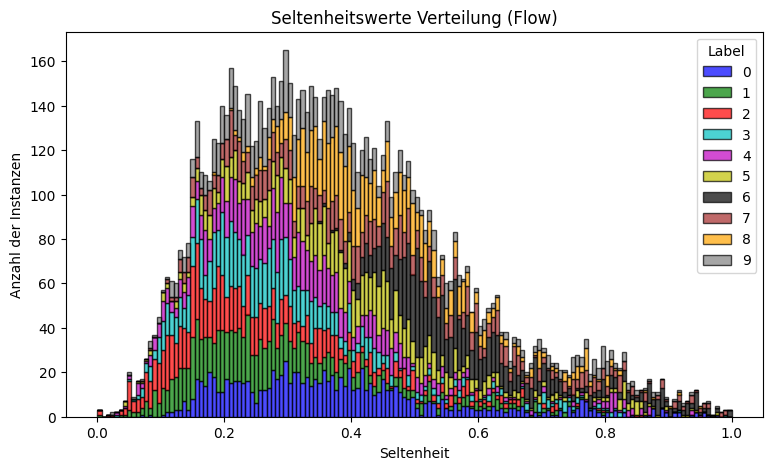

In [335]:
# Plotte Rarity Scores zwischen 0.5 und 1 aller Ziffern mit Label

plt.figure(figsize=(9, 5))
plt.title('Seltenheitswerte Verteilung (Flow)')

# Liste mit Farben für die Labels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange', 'gray']

# Labels definieren
labels = np.array(extracted_numbers, dtype=int)

# Erstelle  Histogramm
plt.hist([rarityScore_flow[labels == i] for i in range(10)], range=[0, 1],  bins=150, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(10)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Label')
plt.show()

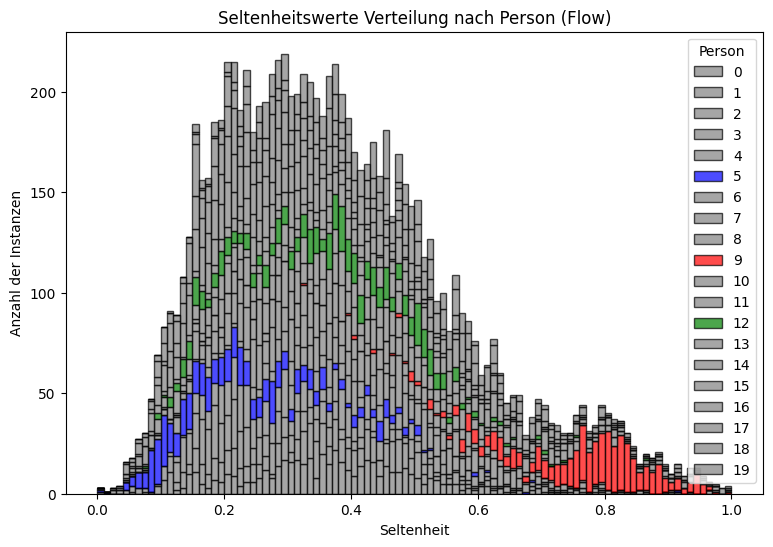

In [517]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9, 6))
plt.title('Seltenheitswerte Verteilung nach Person (Flow)')

# Liste mit Farben für die Labels
colors = ['gray'] * 20  # Alle Labels zunächst auf Grau setzen
highlighted_labels = [5, 9, 12]  # Personen, die hervorgehoben werden sollen
highlight_colors = ['b', 'r', 'g']  # Farben für die hervorgehobenen Personen

# Farben für hervorgehobene Personen festlegen
for i, label in enumerate(highlighted_labels):
    colors[label] = highlight_colors[i]

# Labels definieren
labels = np.array(extracted_voices, dtype=int)

# Erstelle Histogramm
plt.hist([rarityScore_flow[labels == i] for i in range(20)], range=[0, 1], bins=100, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(20)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Person')
plt.show()


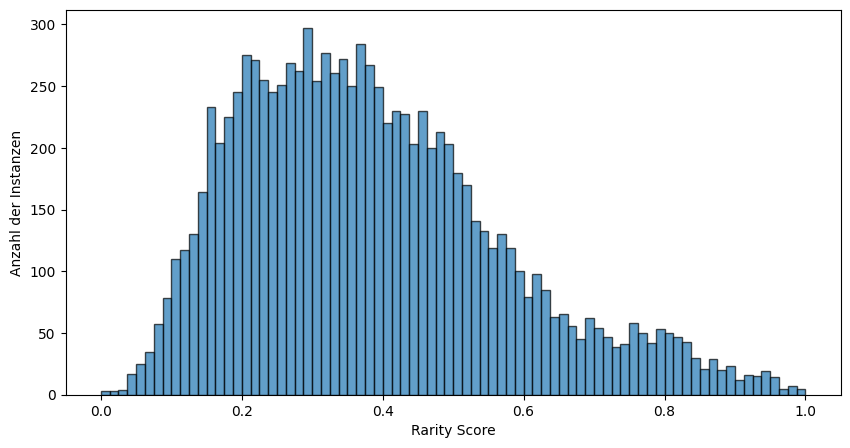

In [19]:
# Erstelle  Histogramm der Ähnlichkeitsverteilungen
plt.figure(figsize=(10, 5))
plt.hist(rarityScore_flow, bins=80, edgecolor='black', alpha=0.7, range=[0,1])

plt.xlabel('Rarity Score')
plt.ylabel('Anzahl der Instanzen')
plt.show()

# Ausreißer Methoden

### LOF

In [20]:
from pyod.models.lof import LOF

# LOF-Modell mit 200 Nachbarn instanziieren
lof = LOF(n_neighbors=200, novelty=True, metric='cosine')

# LOF an der Ähnlichkeitsmatrix anpassen
lof.fit(distances)

# Anomalie-Scores berechnen
rarity_score_lof = lof.decision_function(distances)

# Normalisierung der Scores
min_score = min(rarity_score_lof)
max_score = max(rarity_score_lof)
rarity_score_lof = (rarity_score_lof - min_score) / (max_score - min_score)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


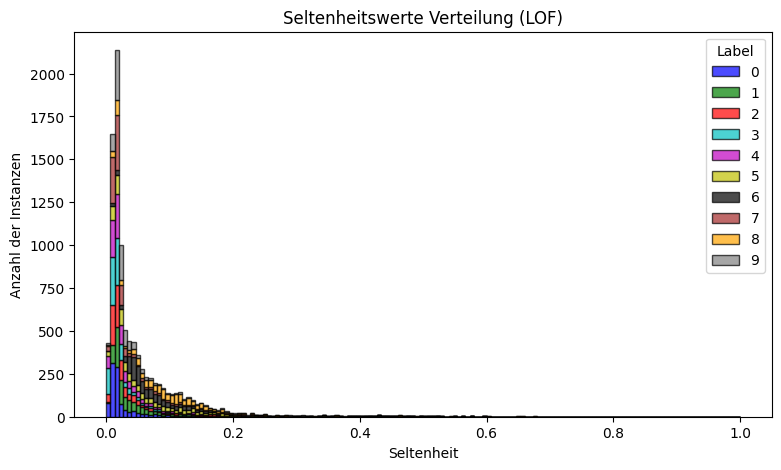

In [336]:
# Plotte Rarity Scores zwischen 0.5 und 1 aller Ziffern mit Label

plt.figure(figsize=(9, 5))
plt.title('Seltenheitswerte Verteilung (LOF)')

# Liste mit Farben für die Labels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange', 'gray']

# Labels definieren
labels = np.array(extracted_numbers, dtype=int)

# Erstelle  Histogramm
plt.hist([rarity_score_lof[labels == i] for i in range(10)], range=[0, 1],  bins=150, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(10)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Label')
plt.show()

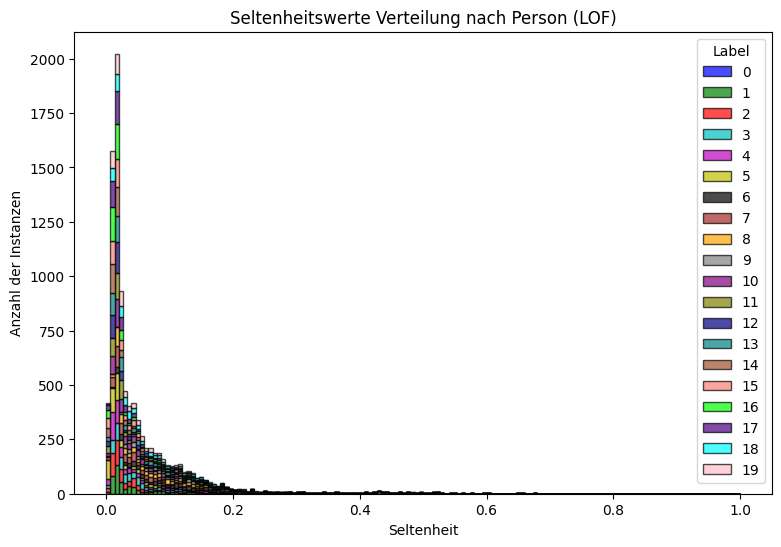

In [362]:
# Plotte Rarity Scores zwischen 0.5 und 1 aller Ziffern mit Label

plt.figure(figsize=(9, 6))
plt.title('Seltenheitswerte Verteilung nach Person (LOF)')

# Liste mit Farben für die Labels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange', 'gray', 'purple', 'olive', 'navy', 'teal', 'sienna', 'salmon', 'lime', 'indigo', 'cyan', 'pink']

# Labels definieren
labels = np.array(extracted_voices, dtype=int)

# Erstelle  Histogramm
plt.hist([rarity_score_lof[labels == i] for i in range(20)], range=[0, 1],  bins=150, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(20)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Label')
plt.show()

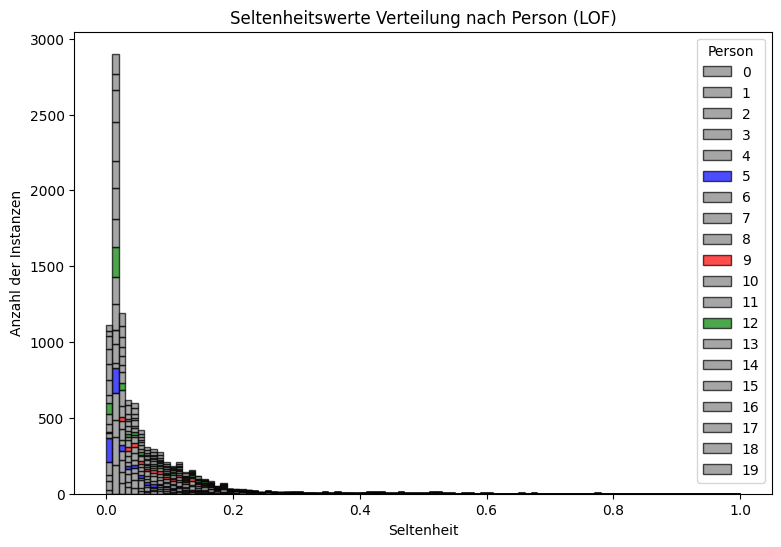

In [516]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9, 6))
plt.title('Seltenheitswerte Verteilung nach Person (LOF)')

# Liste mit Farben für die Labels
colors = ['gray'] * 20  # Alle Labels zunächst auf Grau setzen
highlighted_labels = [5, 9, 12]  # Personen, die hervorgehoben werden sollen
highlight_colors = ['b', 'r', 'g']  # Farben für die hervorgehobenen Personen

# Farben für hervorgehobene Personen festlegen
for i, label in enumerate(highlighted_labels):
    colors[label] = highlight_colors[i]

# Labels definieren
labels = np.array(extracted_voices, dtype=int)

# Erstelle Histogramm
plt.hist([rarity_score_lof[labels == i] for i in range(20)], range=[0, 1], bins=100, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(20)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Person')
plt.show()


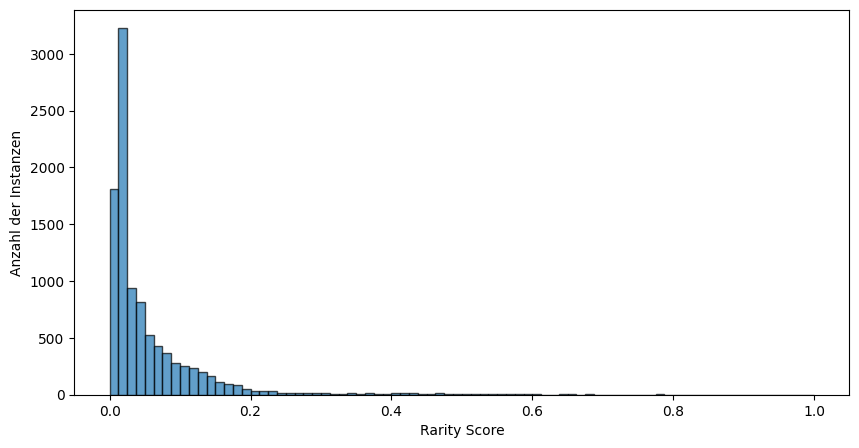

In [24]:
# Erstelle  Histogramm der Ähnlichkeitsverteilungen
plt.figure(figsize=(10, 5))
plt.hist(rarity_score_lof, bins=80, edgecolor='black', alpha=0.7, range=[0,1])

plt.xlabel('Rarity Score')
plt.ylabel('Anzahl der Instanzen')
plt.show()

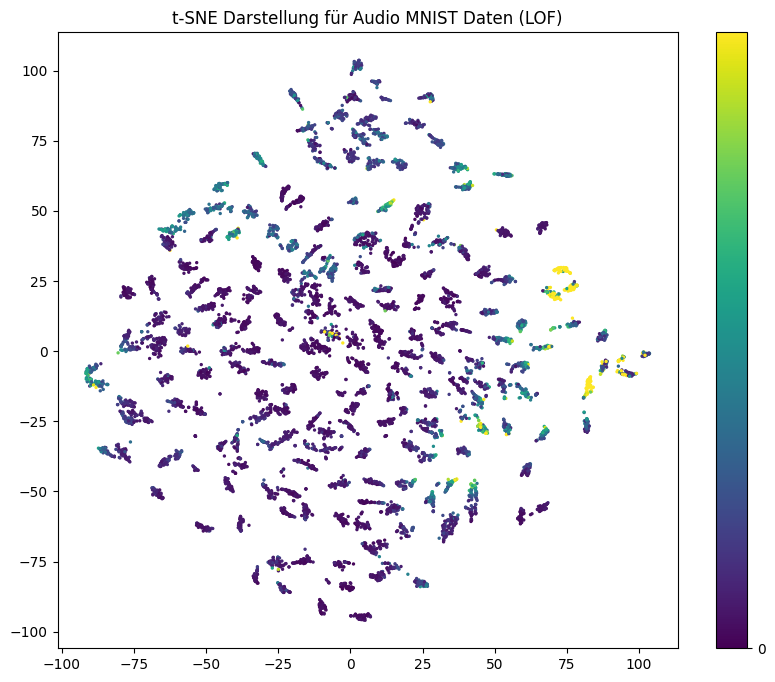

In [342]:
# Rarity Score TSNE Plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], s=2, c=rarity_score_lof, cmap='viridis', vmax=0.3)
plt.colorbar(sc, ticks=range(10))
plt.title('t-SNE Darstellung für Audio MNIST Daten (LOF)')
plt.show()

### KNN

In [25]:
from pyod.models.knn import KNN

# KNN-Modell mit 20 Nachbarn instanziieren
knn = KNN(n_neighbors=200, contamination=0.1, metric='euclidean')

# KNN an der Ähnlichkeitsmatrix anpassen
knn.fit(distances)

# Anomalie-Scores berechnen
outlier_scores_knn = knn.decision_function(distances)

# Normalisierung der Scores
min_score = min(outlier_scores_knn)
max_score = max(outlier_scores_knn)
rarity_score_knn = (outlier_scores_knn - min_score) / (max_score - min_score)

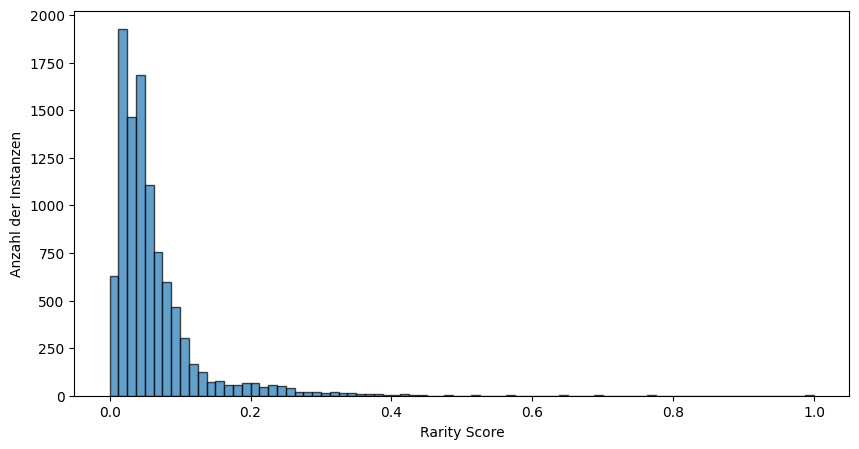

In [26]:
# Erstelle  Histogramm der Ähnlichkeitsverteilungen
plt.figure(figsize=(10, 5))
plt.hist(rarity_score_knn, bins=80, edgecolor='black', alpha=0.7, range=[0,1])

plt.xlabel('Rarity Score')
plt.ylabel('Anzahl der Instanzen')
plt.show()

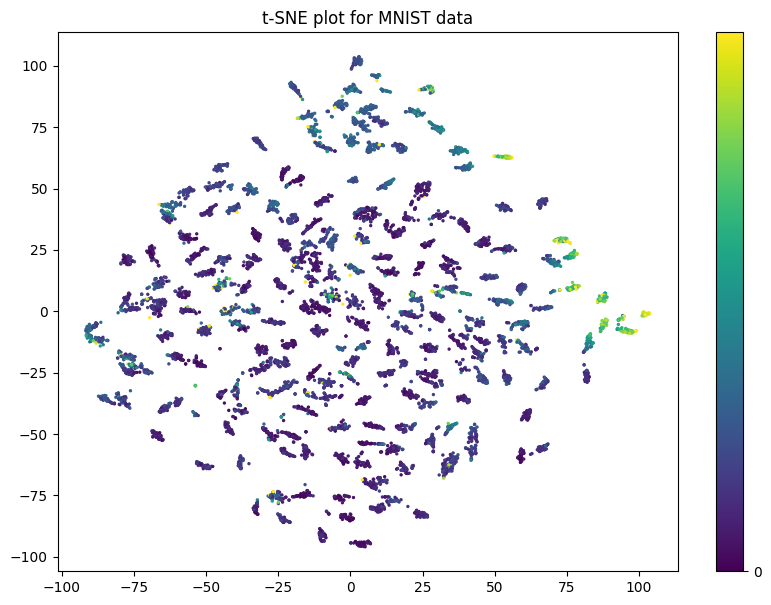

In [28]:
# Rarity Score TSNE Plot
plt.figure(figsize=(10, 7))
sc = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], s=2, c=rarity_score_knn, cmap='viridis', vmax=0.3)
plt.colorbar(sc, ticks=range(10))
plt.title('t-SNE plot for MNIST data')
plt.show()

### SOS

In [29]:
from pyod.models.sos import SOS

# SOS-Modell mit Standardparametern instanziieren
sos = SOS(metric='euclidean', perplexity=200)

# SOS an der Ähnlichkeitsmatrix anpassen
sos.fit(distances)

# Anomalie-Scores berechnen
outlier_scores_sos = sos.decision_function(distances)

# Normalisierung der Scores
min_score = min(outlier_scores_sos)
max_score = max(outlier_scores_sos)
rarity_score_sos = (outlier_scores_sos - min_score) / (max_score - min_score)


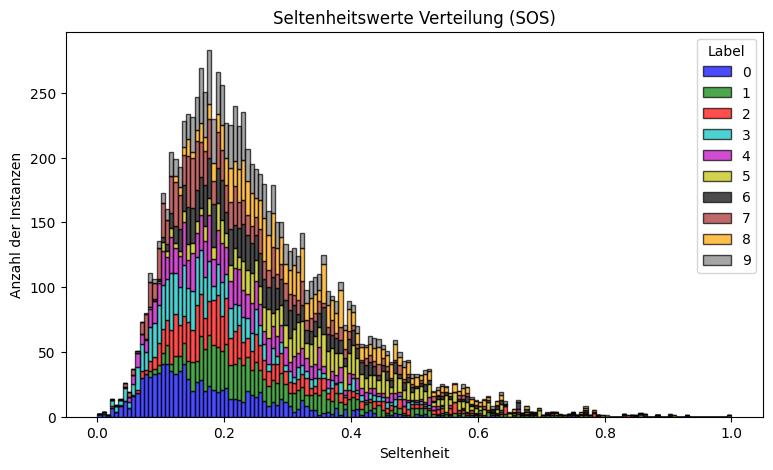

In [337]:
# Plotte Rarity Scores zwischen 0.5 und 1 aller Ziffern mit Label

plt.figure(figsize=(9, 5))
plt.title('Seltenheitswerte Verteilung (SOS)')

# Liste mit Farben für die Labels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange', 'gray']

# Labels definieren
labels = np.array(extracted_numbers, dtype=int)

# Erstelle  Histogramm
plt.hist([rarity_score_sos[labels == i] for i in range(10)], range=[0, 1],  bins=150, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(10)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Label')
plt.show()

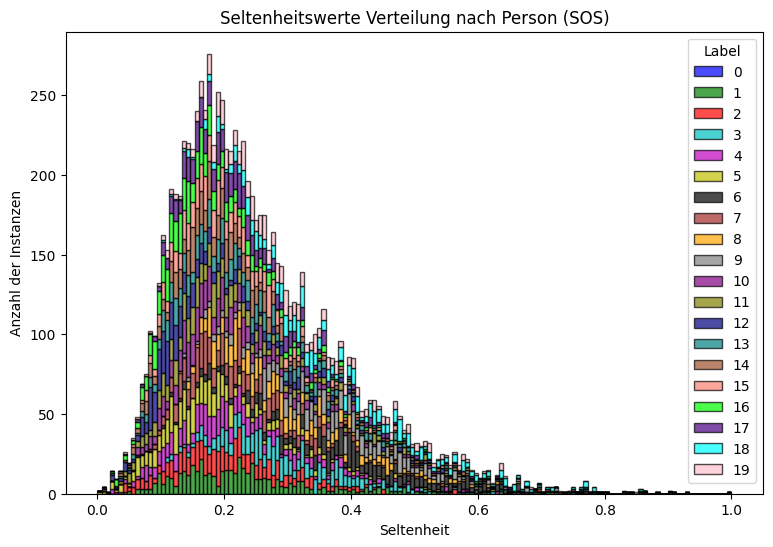

In [363]:
# Plotte Rarity Scores zwischen 0.5 und 1 aller Ziffern mit Label

plt.figure(figsize=(9, 6))
plt.title('Seltenheitswerte Verteilung nach Person (SOS)')

# Liste mit Farben für die Labels
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown', 'orange', 'gray', 'purple', 'olive', 'navy', 'teal', 'sienna', 'salmon', 'lime', 'indigo', 'cyan', 'pink']

# Labels definieren
labels = np.array(extracted_voices, dtype=int)

# Erstelle  Histogramm
plt.hist([rarity_score_sos[labels == i] for i in range(20)], range=[0, 1],  bins=150, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(20)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Label')
plt.show()

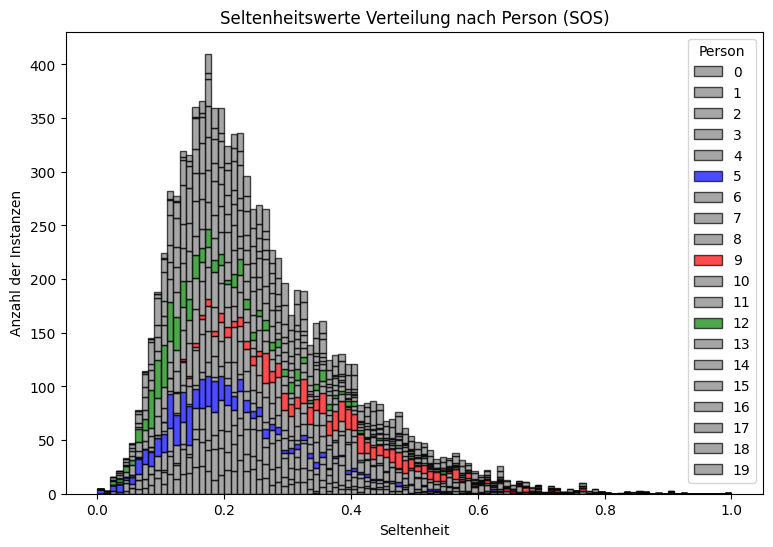

In [515]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9, 6))
plt.title('Seltenheitswerte Verteilung nach Person (SOS)')

# Liste mit Farben für die Labels
colors = ['gray'] * 20  # Alle Labels zunächst auf Grau setzen
highlighted_labels = [5, 9, 12]  # Personen, die hervorgehoben werden sollen
highlight_colors = ['b', 'r', 'g']  # Farben für die hervorgehobenen Personen

# Farben für hervorgehobene Personen festlegen
for i, label in enumerate(highlighted_labels):
    colors[label] = highlight_colors[i]

# Labels definieren
labels = np.array(extracted_voices, dtype=int)

# Erstelle Histogramm
plt.hist([rarity_score_sos[labels == i] for i in range(20)], range=[0, 1], bins=100, color=colors, edgecolor='black', alpha=0.7, stacked=True, label=[str(i) for i in range(20)])

plt.xlabel('Seltenheit')
plt.ylabel('Anzahl der Instanzen')
plt.legend(title='Person')
plt.show()


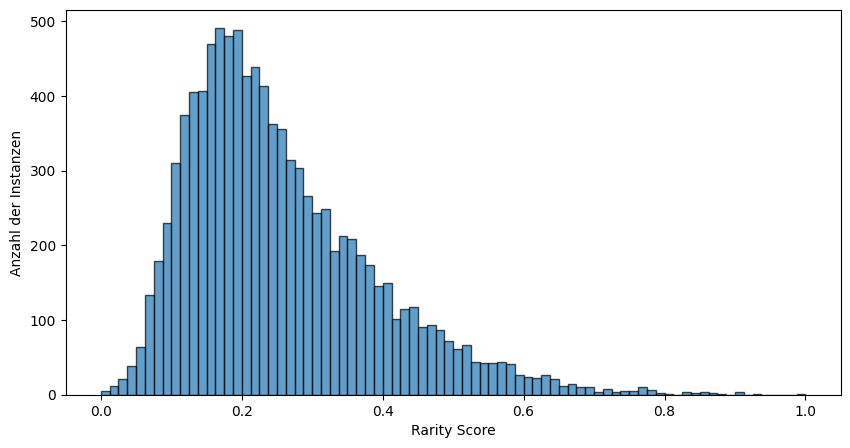

In [30]:
# Erstelle  Histogramm der Ähnlichkeitsverteilungen
plt.figure(figsize=(10, 5))
plt.hist(rarity_score_sos, bins=80, edgecolor='black', alpha=0.7, range=[0,1])

plt.xlabel('Rarity Score')
plt.ylabel('Anzahl der Instanzen')
plt.show()

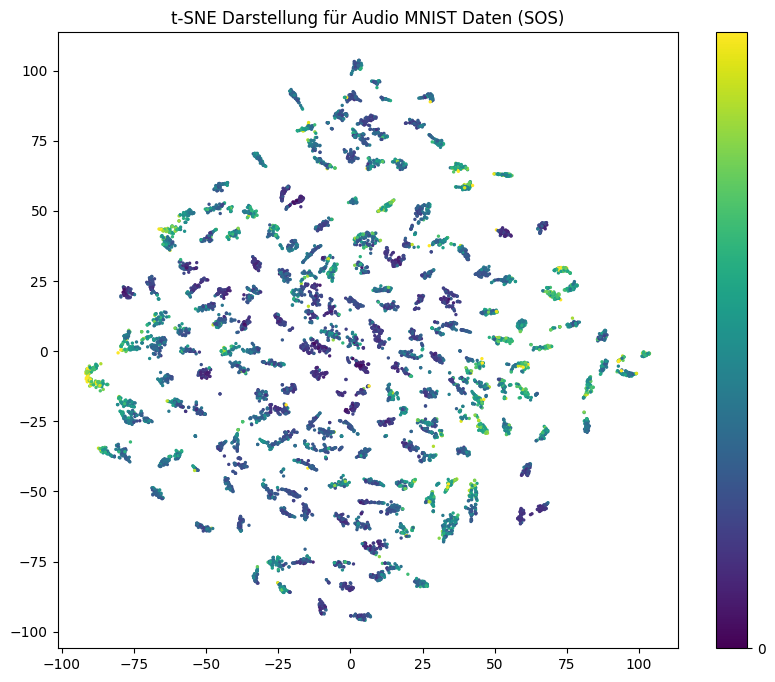

In [343]:
# Rarity Score TSNE Plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], s=2, c=rarity_score_sos, cmap='viridis', vmax=0.7)
plt.colorbar(sc, ticks=range(10))
plt.title('t-SNE Darstellung für Audio MNIST Daten (SOS)')
plt.show()

## Reduziere Datensatz (weniger 2)

In [298]:
# Erstelle die Listen `label_2_files` und `non_label_2_files`
label_2_files = [file for file, label in zip(audio_files, extracted_numbers) if label == 2][:200]
non_label_2_files = [file for file, label in zip(audio_files, extracted_numbers) if label != 2]

# Kombiniere die Dateien
combined_files = label_2_files + non_label_2_files

# Finde die Indizes der kombinierten Dateien in der ursprünglichen Liste
combined_indices = [audio_files.index(file) for file in combined_files]

# Erstelle eine neue Distanzmatrix, die nur die kombinierten Dateien berücksichtigt
distances_red2 = distances[np.ix_(combined_indices, combined_indices)]
distances_red2.shape

(9200, 9200)

In [252]:
# Zuerst trennen wir die Dateien mit Label "2" und begrenzen diese auf 200
label_2_files = [file for file, label in zip(audio_files, extracted_numbers) if label == 2][:200]

# Dann filtern wir alle Dateien, die nicht Label "2" haben
non_label_2_files = [file for file, label in zip(audio_files, extracted_numbers) if label != 2]

# Jetzt kombinieren wir die begrenzte Liste von Label "2" Dateien mit den anderen Dateien
combined_files = label_2_files + non_label_2_files

# Danach wenden wir Ihre bestehende Logik zur Merkmalsextraktion und zum Padding auf diese kombinierte Liste an
audio_features = []
max_length = 0
for full_path in combined_files:
    mfccs = load_and_extract_features(full_path)
    max_length = max(max_length, mfccs.shape[1])
    audio_features.append(mfccs)

# Zweiter Durchlauf: Padding der MFCCs zur maximalen Länge
padded_audio_features = []
for mfccs in audio_features:
    pad_width = max_length - mfccs.shape[1]
    padded_mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    padded_audio_features.append(padded_mfccs.flatten())  # Flatten the arrays

# Umwandlung in ein numpy-Array für die Distanzberechnung
padded_audio_features = np.array(padded_audio_features)

# Berechnung der paarweisen Abstände zwischen den Audiodateien
from scipy.spatial.distance import cdist
distances_reduced = cdist(padded_audio_features, padded_audio_features, metric='euclidean')


In [299]:
# Liste für die extrahierten Zahlen
extracted_numbers_red = []

for file in combined_files:
    # Trenne den Dateinamen an den Unterstrichen
    parts = file.split('_')
    # Extrahiere die erste Zahl (als String) und konvertiere sie in ein Integer
    number = int(parts[0].split('/')[-1])
    # Füge die Zahl zur Liste hininzu
    extracted_numbers_red.append(number)

In [300]:
scores_reduced = distances_red2

In [301]:
# Grenzwert n_neighbours
n_neighbours = 500

# Sortiere die Scores und nimm die ersten n_neighbours Werte
sorted_scores = [sorted(score_array)[:n_neighbours] for score_array in scores_reduced]

# Berechne die Summe der Werte und die Anzahl der Instanzen in jedem Array
value_sums = [sum(score_array) for score_array in sorted_scores]
instance_counts = [len(score_array) for score_array in sorted_scores]

# Berechne den Durchschnitt für jedes Array
averages = [value_sum / instance_count for value_sum, instance_count in zip(value_sums, instance_counts)]

In [289]:
# Normalisierung und Umkehrung
rarityScore_red = averages
min_score = min(rarityScore_red)
max_score = max(rarityScore_red)
rarityScore_red = (rarityScore_red - min_score) / (max_score - min_score)

### Flow

In [302]:
scores_normalized = (scores_reduced - scores_reduced.min()) / (scores_reduced.max() - scores_reduced.min())

In [303]:
def compute_flows(distance, decay=10):
    return np.exp(-decay * distance)

sorted_ids = np.argsort(scores_normalized)

n_next_hubs = 100

# iterative flow search
inward_flow_results = np.zeros(len(scores_normalized))
for id in tqdm(range(len(scores_normalized))):
    idx = sorted_ids[id][1:(n_next_hubs + 1)]
    inward_flow_results[id] += compute_flows(scores_normalized[id, idx]).sum()

100%|██████████| 9200/9200 [00:00<00:00, 94682.57it/s]


In [304]:
# Normalisierung und Umkehrung
rarityScore_flow_red = 1-inward_flow_results
min_score = min(rarityScore_flow_red)
max_score = max(rarityScore_flow_red)
rarityScore_flow_red = (rarityScore_flow_red - min_score) / (max_score - min_score)

## Vergleich der Methoden (2 Reduktion)

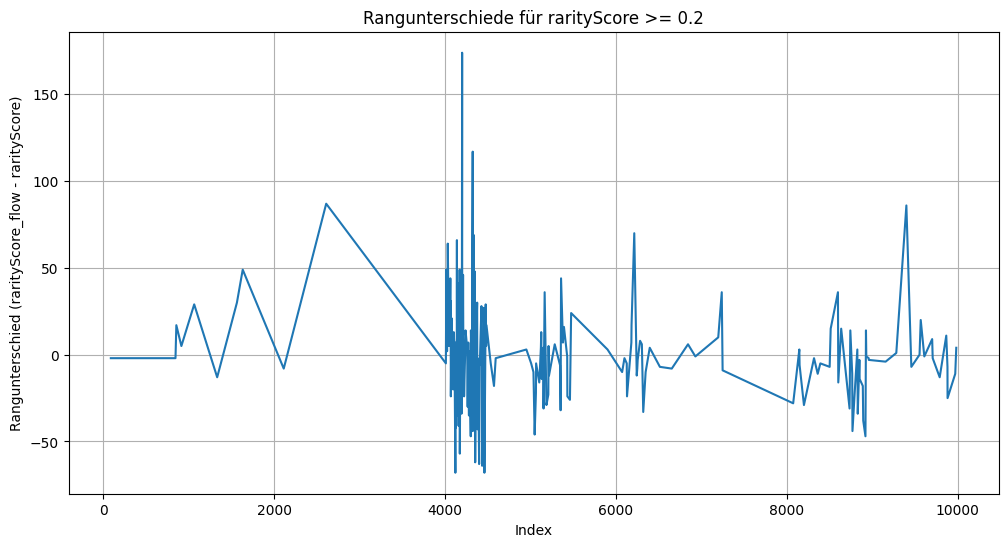

In [306]:
# Umwandlung in NumPy-Arrays
rarityScore = np.array(rarityScore)
rarityScore_flow = np.array(rarityScore_flow)

# Filtern der Indizes basierend auf einem rarityScore von mindestens 0.2
indices = np.arange(len(rarityScore))
filtered_indices = indices[rarityScore >= 0.5]

# Berechnen der Ränge nur für gefilterte Indizes
filtered_ranks_rarityScore = np.argsort(np.argsort(rarityScore[filtered_indices]))
filtered_ranks_rarityScore_flow = np.argsort(np.argsort(rarityScore_flow[filtered_indices]))

# Berechnen der Rangunterschiede
rank_differences = filtered_ranks_rarityScore_flow - filtered_ranks_rarityScore

# Erstellen des Liniendiagramms
plt.figure(figsize=(12, 6))
plt.plot(filtered_indices, rank_differences)

# Beschriftungen
plt.xlabel('Index')
plt.ylabel('Rangunterschied (rarityScore_flow - rarityScore)')
plt.title('Rangunterschiede für rarityScore >= 0.2')
plt.grid(True)

# Anzeigen des Plots
plt.show()


Mittelwerte : 0.07893065912205982 0.12125411730088924 0.21260449949103233 0.2924795509988811


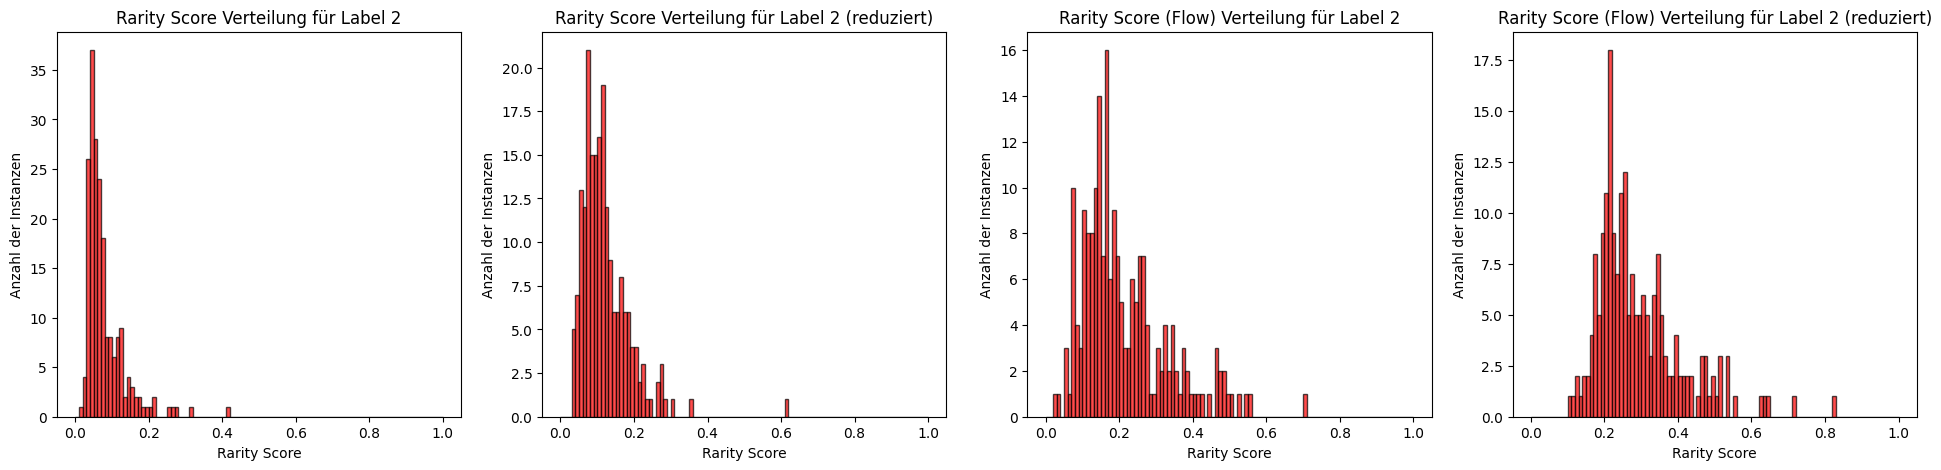

In [305]:
# Labels definieren
labels_reduced = extracted_numbers_red
labels = extracted_numbers
filtered_indices = [index for index, value in enumerate(extracted_numbers) if value == 2]
filtered_indices_red = [index for index, value in enumerate(extracted_numbers_red) if value == 2]

# Filtern der Daten für Label 2
filtered_rarityScore_red = rarityScore_red[filtered_indices_red]
filtered_rarityScore = rarityScore[filtered_indices[:200]]
filtered_rarityScore_flow_red = rarityScore_flow_red[filtered_indices_red]
filtered_rarityScore_flow = rarityScore_flow[filtered_indices[:200]]

# Erstellen der 4 Histogramme in einer Reihe
fig, axs = plt.subplots(1, 4, figsize=(24, 5))
print('Mittelwerte :', filtered_rarityScore.mean(), filtered_rarityScore_red.mean(), filtered_rarityScore_flow.mean(),filtered_rarityScore_flow_red.mean())

# Histogramm für normale Rarity Scores
axs[0].hist(filtered_rarityScore, range=[0, 1], bins=100, color='red', edgecolor='black', alpha=0.7)
axs[0].set_title('Rarity Score Verteilung für Label 2')
axs[0].set_xlabel('Rarity Score')
axs[0].set_ylabel('Anzahl der Instanzen')

# Histogramm für reduzierte Rarity Scores
axs[1].hist(filtered_rarityScore_red, range=[0, 1], bins=100, color='red', edgecolor='black', alpha=0.7)
axs[1].set_title('Rarity Score Verteilung für Label 2 (reduziert)')
axs[1].set_xlabel('Rarity Score')
axs[1].set_ylabel('Anzahl der Instanzen')

# Histogramm für Flow Rarity Scores
axs[2].hist(filtered_rarityScore_flow, range=[0, 1], bins=100, color='red', edgecolor='black', alpha=0.7)
axs[2].set_title('Rarity Score (Flow) Verteilung für Label 2')
axs[2].set_xlabel('Rarity Score')
axs[2].set_ylabel('Anzahl der Instanzen')

# Histogramm für Flow Rarity Scores
axs[3].hist(filtered_rarityScore_flow_red, range=[0, 1], bins=100, color='red', edgecolor='black', alpha=0.7)
axs[3].set_title('Rarity Score (Flow) Verteilung für Label 2 (reduziert)')
axs[3].set_xlabel('Rarity Score')
axs[3].set_ylabel('Anzahl der Instanzen')

plt.show()


## Reduziere Datensatz (weniger Person 12)

In [296]:
max_files_per_number = 20  # Anzahl der maximalen Dateien pro extracted_number
audio_files_reduced12 = []

# Erstelle ein Dictionary, um die Dateien pro extracted_number zu zählen
files_per_extracted_number = {str(i): 0 for i in range(10)}

# Zufällig auswählen, welche Dateien aus directory "12" behalten werden sollen
for directory in directories:
    directory_path = os.path.join(base_path, directory)
    for file in os.listdir(directory_path):
        if file.endswith('.wav'):
            full_path = os.path.join(directory_path, file)
            extracted_number = file[0]  # Annahme: Die erste Ziffer im Dateinamen gibt das extracted_number an

            # Wenn die Datei aus directory "12" stammt und die maximale Anzahl pro extracted_number nicht erreicht wurde
            if directory == "12" and files_per_extracted_number[extracted_number] < max_files_per_number:
                audio_files_reduced12.append(full_path)
                files_per_extracted_number[extracted_number] += 1
            elif directory != "12":
                audio_files_reduced12.append(full_path)

# Überprüfen der reduzierten Liste
print(f"Anzahl der Audiodateien nach Reduzierung: {len(audio_files_reduced12)}")


Anzahl der Audiodateien nach Reduzierung: 9700


In [309]:
# Liste für die extrahierten Zahlen
extracted_numbers_red = []

for file in audio_files_reduced12:
    # Trenne den Dateinamen an den Unterstrichen
    parts = file.split('_')
    # Extrahiere die erste Zahl (als String) und konvertiere sie in ein Integer
    number = int(parts[0].split('/')[-1])
    # Füge die Zahl zur Liste hininzu
    extracted_numbers_red.append(number)

In [308]:
# Finde die Indizes der Dateien in `audio_files_reduced12` in der ursprünglichen Liste `audio_files`
reduced_indices = [audio_files.index(file) for file in audio_files_reduced12]

# Erstelle eine neue Distanzmatrix, die nur die reduzierten Dateien berücksichtigt
distances_red12 = distances[np.ix_(reduced_indices, reduced_indices)]
distances_red12.shape 

(9700, 9700)

### Rarity Score Kompakt

In [310]:
scores_reduced = distances_red12

# Grenzwert n_neighbours
n_neighbours = 500

# Sortiere die Scores und nimm die ersten n_neighbours Werte
sorted_scores = [sorted(score_array)[:n_neighbours] for score_array in scores_reduced]

# Berechne die Summe der Werte und die Anzahl der Instanzen in jedem Array
value_sums = [sum(score_array) for score_array in sorted_scores]
instance_counts = [len(score_array) for score_array in sorted_scores]

# Berechne den Durchschnitt für jedes Array
averages = [value_sum / instance_count for value_sum, instance_count in zip(value_sums, instance_counts)]

# Normalisierung und Umkehrung
rarityScore_red = averages
min_score = min(rarityScore_red)
max_score = max(rarityScore_red)
rarityScore_red = (rarityScore_red - min_score) / (max_score - min_score)

# FLOW
scores_normalized = (scores_reduced - scores_reduced.min()) / (scores_reduced.max() - scores_reduced.min())

def compute_flows(distance, decay=10):
    return np.exp(-decay * distance)

sorted_ids = np.argsort(scores_normalized)

n_next_hubs = 100

# iterative flow search
inward_flow_results = np.zeros(len(scores_normalized))
for id in tqdm(range(len(scores_normalized))):
    idx = sorted_ids[id][1:(n_next_hubs + 1)]
    inward_flow_results[id] += compute_flows(scores_normalized[id, idx]).sum()

# Normalisierung und Umkehrung
rarityScore_flow_red = 1-inward_flow_results
min_score = min(rarityScore_flow_red)
max_score = max(rarityScore_flow_red)
rarityScore_flow_red = (rarityScore_flow_red - min_score) / (max_score - min_score)

100%|██████████| 9700/9700 [00:00<00:00, 96903.98it/s]


## Vergleich der Methoden (Person 12 Reduktion)

Mittelwerte : 0.10912955005284754 0.11383175437188513 0.3752495147006157 0.4003884030516015


Text(0, 0.5, 'Anzahl der Instanzen')

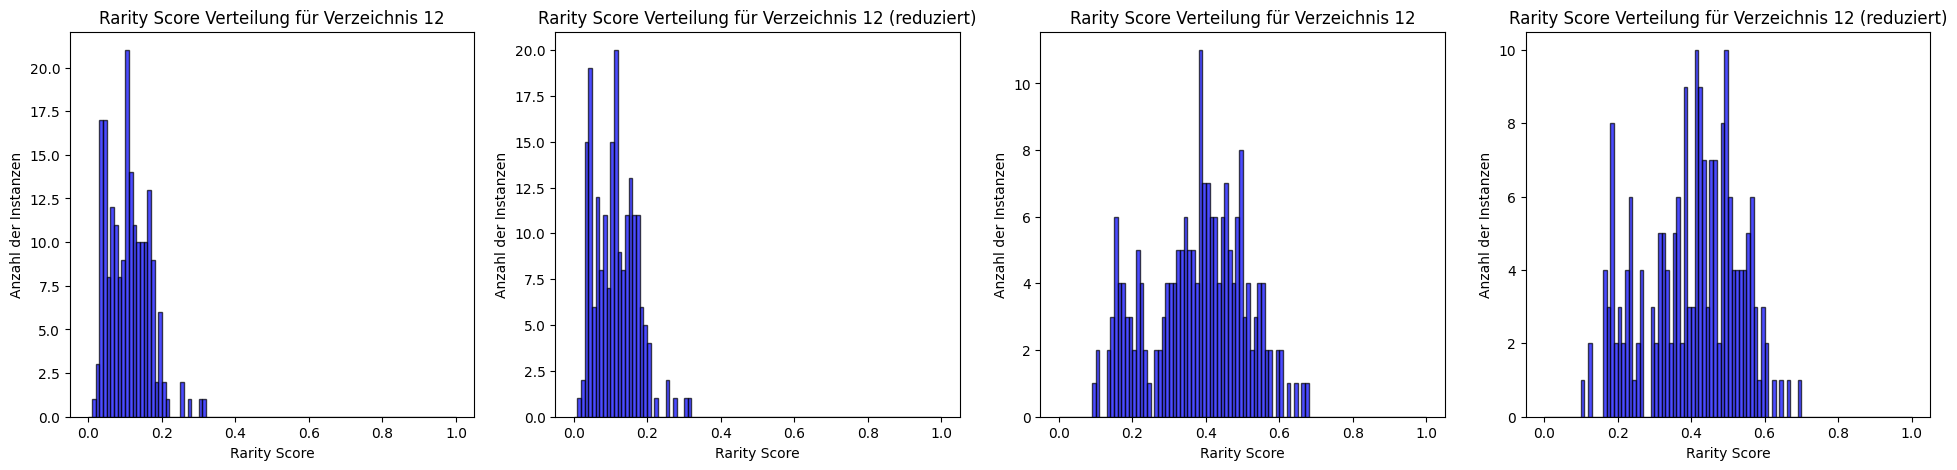

In [359]:
# Indizes für Dateien aus Verzeichnis "12" extrahieren
indices_dir_12 = [index for index, file in enumerate(audio_files) if file.split('_')[1] == '12']
indices_dir_12_red = [index for index, file in enumerate(audio_files_reduced12) if file.split('_')[1] == '12']
indices_dir_12_complete = [element for element in reduced_indices if element in indices_dir_12]

# Filtern der Daten für Verzeichnis "12"
filtered_rarityScore_dir_12 = rarityScore[indices_dir_12_complete]
filtered_rarityScore_red_dir_12 = rarityScore_red[indices_dir_12_red]
filtered_rarityScore_flow_dir_12 = rarityScore_flow[indices_dir_12_complete]
filtered_rarityScore_flow_red_dir_12 = rarityScore_flow_red[indices_dir_12_red]

# Erstellen der 4 Histogramme in einer Reihe
fig, axs = plt.subplots(1, 4, figsize=(24, 5))
print('Mittelwerte :', filtered_rarityScore_dir_12.mean(), filtered_rarityScore_red_dir_12.mean(), filtered_rarityScore_flow_dir_12.mean(), filtered_rarityScore_flow_red_dir_12.mean())

# Histogramm für normale Rarity Scores
axs[0].hist(filtered_rarityScore_dir_12, range=[0, 1], bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_title('Rarity Score Verteilung für Verzeichnis 12')
axs[0].set_xlabel('Rarity Score')
axs[0].set_ylabel('Anzahl der Instanzen')

# Histogramm für reduzierte Rarity Scores
axs[1].hist(filtered_rarityScore_red_dir_12, range=[0, 1], bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[1].set_title('Rarity Score Verteilung für Verzeichnis 12 (reduziert)')
axs[1].set_xlabel('Rarity Score')
axs[1].set_ylabel('Anzahl der Instanzen')

# Histogramm für normale Rarity Scores (Flow)
axs[2].hist(filtered_rarityScore_flow_dir_12, range=[0, 1], bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[2].set_title('Rarity Score Verteilung für Verzeichnis 12')
axs[2].set_xlabel('Rarity Score')
axs[2].set_ylabel('Anzahl der Instanzen')

# Histogramm für reduzierte Rarity Scores (Flow)
axs[3].hist(filtered_rarityScore_flow_red_dir_12, range=[0, 1], bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[3].set_title('Rarity Score Verteilung für Verzeichnis 12 (reduziert)')
axs[3].set_xlabel('Rarity Score')
axs[3].set_ylabel('Anzahl der Instanzen')


## Multi Test: Reduziere Person 12 (gleichmässig)

In [169]:
# Beispiele pro Ziffer in Ordner (Person)
examples_per_digit = [40, 20, 10, 5]

# Funktion, um Seltenheitswerte basierend auf Distanz und Anomalie-Erkennungsmodellen zu berechnen
def calculate_rarity_scores(audio_files_reduced, distances, n_neighbours=200):
    reduced_indices = [audio_files.index(file) for file in audio_files_reduced]
    distances_red = distances[np.ix_(reduced_indices, reduced_indices)]

    # N-Mean Methode
    sorted_scores = [sorted(score_array)[:n_neighbours] for score_array in distances_red]
    value_sums = [sum(score_array) for score_array in sorted_scores]
    instance_counts = [len(score_array) for score_array in sorted_scores]
    averages = [value_sum / instance_count for value_sum, instance_count in zip(value_sums, instance_counts)]

    # Normalisierung und Umkehrung
    rarityScore = averages
    min_score = min(rarityScore)
    max_score = max(rarityScore)
    rarityScore = (rarityScore - min_score) / (max_score - min_score)
    
    # Flussbasierte Seltenheitswerte
    scores_normalized = (distances_red - distances_red.min()) / (distances_red.max() - distances_red.min())
    sorted_ids = np.argsort(scores_normalized)
    n_next_hubs = 200
    inward_flow_results = np.zeros(len(scores_normalized))
    
    for id in range(len(scores_normalized)):
        idx = sorted_ids[id][1:(n_next_hubs + 1)]
        inward_flow_results[id] += np.exp(-10 * scores_normalized[id, idx]).sum()
    
    rarityScore_flow_red = 1 - inward_flow_results
    rarityScore_flow_red = (rarityScore_flow_red - np.min(rarityScore_flow_red)) / (np.max(rarityScore_flow_red) - np.min(rarityScore_flow_red))
    
    # LOF
    lof = LOF(n_neighbors=n_neighbours, novelty=True, metric='cosine')
    lof.fit(distances_red)
    rarity_score_lof = lof.decision_function(distances_red)
    rarity_score_lof = (rarity_score_lof - np.min(rarity_score_lof)) / (np.max(rarity_score_lof) - np.min(rarity_score_lof))

    # SOS
    sos = SOS(metric='euclidean', perplexity=n_neighbours)
    sos.fit(distances_red)
    outlier_scores_sos = sos.decision_function(distances_red)
    rarity_score_sos = (outlier_scores_sos - np.min(outlier_scores_sos)) / (np.max(outlier_scores_sos) - np.min(outlier_scores_sos))

    # Sampling
    sp = Sampling(subset_size=n_neighbours, contamination=0.1, metric='euclidean')
    sp.fit(distances_red)
    outlier_scores_sp = sp.decision_function(distances_red)
    rarity_score_sp = (outlier_scores_sp - np.min(outlier_scores_sp)) / (np.max(outlier_scores_sp) - np.min(outlier_scores_sp))

    return rarityScore, rarityScore_flow_red, rarity_score_lof, rarity_score_sos, rarity_score_sp, reduced_indices

# Hauptfunktion zur Reduzierung und Berechnung der Seltenheitswerte
def reduce_and_calculate_rarity(directories, examples_per_digit):
    rarity_scores_reduced12 = []
    rarity_scores_reduced12_flow = []
    rarity_scores_reduced12_lof = []
    rarity_scores_reduced12_sos = []
    rarity_scores_reduced12_sp = []
    audio_files_reduced_list = []  # Liste für audio_files_reduced
    reduced_indices_list = []  # Liste für reduced_indices
    
    for max_files_per_number in examples_per_digit:
        files_per_extracted_number = {str(i): 0 for i in range(10)}
        audio_files_reduced = []
        reduced_indices = []
        
        for directory in directories:
            directory_path = os.path.join(base_path, directory)
            for file in os.listdir(directory_path):
                if file.endswith('.wav'):
                    full_path = os.path.join(directory_path, file)
                    extracted_number = file[0] 
                    
                    if directory == "12" and files_per_extracted_number[extracted_number] < max_files_per_number:
                        audio_files_reduced.append(full_path)
                        reduced_indices.append(files_per_extracted_number[extracted_number])
                        files_per_extracted_number[extracted_number] += 1
                    elif directory != "12":
                        audio_files_reduced.append(full_path)
                        reduced_indices.append(files_per_extracted_number[extracted_number])
        
        # Berechne Seltenheitswerte für die reduzierte Liste mit verschiedenen Methoden
        scores, flow_scores, lof_scores, sos_scores, sp_scores, reduced_indices = calculate_rarity_scores(audio_files_reduced, distances)
        
        # Anstatt die Scores direkt in die Hauptliste einzufügen, fügen Sie sie zu den spezifischen Listen hinzu
        for scores, flow_scores, lof_scores, sos_scores, sp_scores, _ in [calculate_rarity_scores(audio_files_reduced, distances)]:
            rarity_scores_reduced12.append(scores)
            rarity_scores_reduced12_flow.append(flow_scores)
            rarity_scores_reduced12_lof.append(lof_scores)
            rarity_scores_reduced12_sos.append(sos_scores)
            rarity_scores_reduced12_sp.append(sp_scores)
            audio_files_reduced_list.append(audio_files_reduced)
            reduced_indices_list.append(reduced_indices)

    # Rückgabe der organisierten Listen
    return rarity_scores_reduced12, rarity_scores_reduced12_flow, rarity_scores_reduced12_lof, rarity_scores_reduced12_sos, rarity_scores_reduced12_sp, audio_files_reduced_list, reduced_indices_list

# Aufrufen der Hauptfunktion und Organisieren der Ergebnisse entsprechend
rarity_scores_reduced12, rarity_scores_reduced12_flow, rarity_scores_reduced12_lof, rarity_scores_reduced12_sos, rarity_scores_reduced12_sp, reduced_indices, audio_files_reduced12 = reduce_and_calculate_rarity(directories, examples_per_digit)

KeyboardInterrupt: 

In [118]:
for i, scores in enumerate(rarity_scores_reduced12):
    rarity_scores_reduced12[i] = np.array(rarity_scores_reduced12[i])
    rarity_scores_reduced12_flow[i] = np.array(rarity_scores_reduced12_flow[i])
    rarity_scores_reduced12_lof[i] = np.array(rarity_scores_reduced12_lof[i])
    rarity_scores_reduced12_sos[i] = np.array(rarity_scores_reduced12_sos[i])
    rarity_scores_reduced12_sp[i] = np.array(rarity_scores_reduced12_sp[i])

In [466]:
# Indizes für Dateien aus Verzeichnis "12" extrahieren
indices_dir_12 = [index for index, file in enumerate(audio_files) if file.split('_')[1] == '12']

rarity_scores_means = []
rarity_scores_red_means = []
rarity_scores_flow_means = []
rarity_scores_red_flow_means = []
rarity_scores_lof_means = []
rarity_scores_red_lof_means = []
rarity_scores_sos_means = []
rarity_scores_red_sos_means = []
rarity_scores_sp_means = []
rarity_scores_red_sp_means = []

# Mittelwert Loop
for i, (scores, scores_flow, scores_lof, scores_sos, scores_sp) in enumerate(zip(rarity_scores_reduced12, rarity_scores_reduced12_flow, rarity_scores_reduced12_lof, rarity_scores_reduced12_sos, rarity_scores_reduced12_sp)):
    indices_dir_12_red = [index for index, file in enumerate(audio_files) if file.split('_')[1] == '12' and index in audio_files_reduced12[i]]
    indices_dir_12_complete = [index for index, file in enumerate(reduced_indices[i]) if file.split('_')[1] == '12']
    
    # Filtern der Daten für Verzeichnis 12
    filtered_rarity_score = rarityScore[indices_dir_12_complete]
    filtered_rarity_score_red = scores[indices_dir_12_red]

    filtered_rarity_score_flow = rarityScore_flow[indices_dir_12_complete]
    filtered_rarity_score_red_flow = scores_flow[indices_dir_12_red]
    
    filtered_rarity_score_lof = rarity_score_lof[indices_dir_12_complete]
    filtered_rarity_score_red_lof = scores_lof[indices_dir_12_red]
        
    filtered_rarity_score_sos = rarity_score_sos[indices_dir_12_complete]
    filtered_rarity_score_red_sos = scores_sos[indices_dir_12_red]

    filtered_rarity_score_sp = rarity_score_sp[indices_dir_12_complete]
    filtered_rarity_score_red_sp = scores_sp[indices_dir_12_red]

    # Berechne Mittelwert
    rarity_scores_means.append(filtered_rarity_score.mean())
    rarity_scores_red_means.append(filtered_rarity_score_red.mean())

    rarity_scores_flow_means.append(filtered_rarity_score_flow.mean())
    rarity_scores_red_flow_means.append(filtered_rarity_score_red_flow.mean())

    rarity_scores_lof_means.append(filtered_rarity_score_lof.mean())
    rarity_scores_red_lof_means.append(filtered_rarity_score_red_lof.mean())

    rarity_scores_sos_means.append(filtered_rarity_score_sos.mean())
    rarity_scores_red_sos_means.append(filtered_rarity_score_red_sos.mean())

    rarity_scores_sp_means.append(filtered_rarity_score_sp.mean())
    rarity_scores_red_sp_means.append(filtered_rarity_score_red_sp.mean())

print(rarity_scores_means, '\n ', rarity_scores_red_means ,'\n ' ,rarity_scores_flow_means , '\n ', rarity_scores_red_flow_means, '\n ' ,rarity_scores_lof_means , '\n ', rarity_scores_red_lof_means, '\n ' ,rarity_scores_sos_means , '\n ', rarity_scores_red_sos_means, '\n ' ,rarity_scores_sp_means , '\n ', rarity_scores_red_sp_means)



IndexError: list index out of range

(0.33851010793345176, 0.4383041667265368)

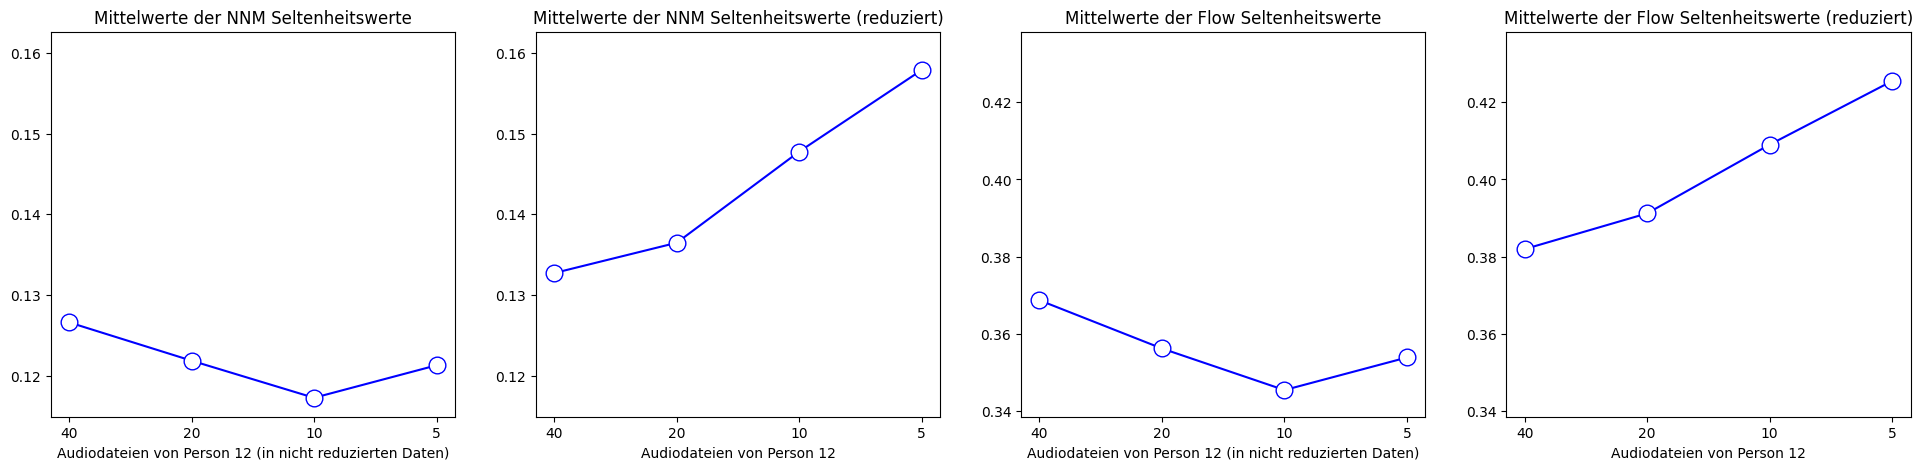

In [469]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

axs[0].plot(rarity_scores_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte der NNM Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit)))
axs[0].set_xticklabels(examples_per_digit)
axs[0].set_xlabel('Audiodateien von Person 12 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_means)*0.98, max(rarity_scores_red_means)*1.03])

axs[1].plot(rarity_scores_red_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte der NNM Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit)))
axs[1].set_xticklabels(examples_per_digit)
axs[1].set_xlabel('Audiodateien von Person 12')
axs[1].set_ylim([min(rarity_scores_means)*0.98, max(rarity_scores_red_means)*1.03])

axs[2].plot(rarity_scores_flow_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte der Flow Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit)))
axs[2].set_xticklabels(examples_per_digit)
axs[2].set_xlabel('Audiodateien von Person 12 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_flow_means)*0.98, max(rarity_scores_red_flow_means)*1.03])

axs[3].plot(rarity_scores_red_flow_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte der Flow Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit)))
axs[3].set_xticklabels(examples_per_digit)
axs[3].set_xlabel('Audiodateien von Person 12')
axs[3].set_ylim([min(rarity_scores_flow_means)*0.98, max(rarity_scores_red_flow_means)*1.03])

(0.16036335079092698, 0.2184237334771707)

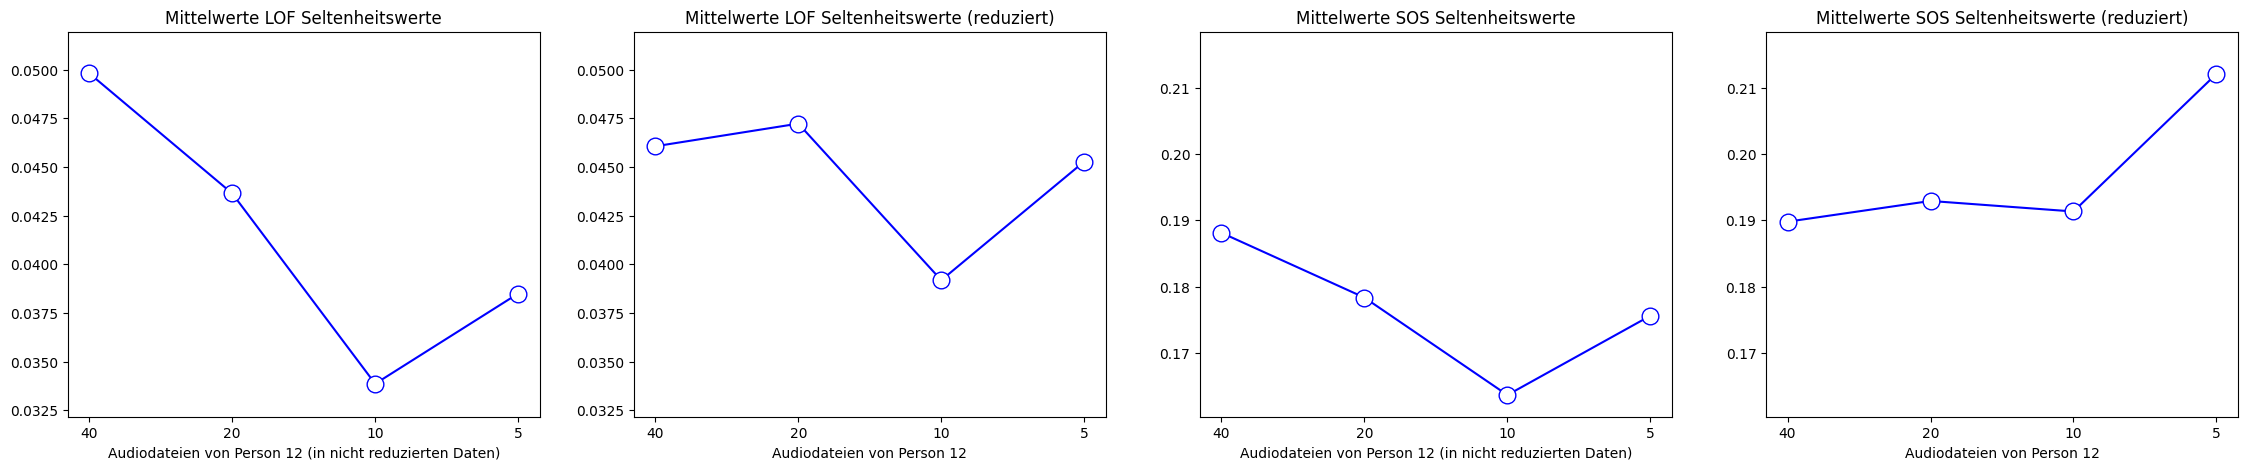

In [471]:
fig, axs = plt.subplots(1, 4, figsize=(28, 5))

axs[0].plot(rarity_scores_lof_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte LOF Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit)))
axs[0].set_xticklabels(examples_per_digit)
axs[0].set_xlabel('Audiodateien von Person 12 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_lof_means)*0.95, max(rarity_scores_red_lof_means)*1.1])

axs[1].plot(rarity_scores_red_lof_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte LOF Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit)))
axs[1].set_xticklabels(examples_per_digit)
axs[1].set_xlabel('Audiodateien von Person 12')
axs[1].set_ylim([min(rarity_scores_lof_means)*0.95, max(rarity_scores_red_lof_means)*1.1])

axs[2].plot(rarity_scores_sos_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte SOS Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit)))
axs[2].set_xticklabels(examples_per_digit)
axs[2].set_xlabel('Audiodateien von Person 12 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_sos_means)*0.98, max(rarity_scores_red_sos_means)*1.03])

axs[3].plot(rarity_scores_red_sos_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte SOS Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit)))
axs[3].set_xticklabels(examples_per_digit)
axs[3].set_xlabel('Audiodateien von Person 12')
axs[3].set_ylim([min(rarity_scores_sos_means)*0.98, max(rarity_scores_red_sos_means)*1.03])

## Multi Test: Reduziere Person 9 (gleichmässig)

In [439]:
# Beispiele pro Ziffer in Ordner (Person)
examples_per_digit_9 = [40, 20, 10, 5]

# Funktion, um Seltenheitswerte basierend auf Distanz und Anomalie-Erkennungsmodellen zu berechnen
def calculate_rarity_scores(audio_files_reduced, distances, n_neighbours=200):
    reduced_indices = [audio_files.index(file) for file in audio_files_reduced]
    distances_red = distances[np.ix_(reduced_indices, reduced_indices)]

    # N-Mean Methode
    sorted_scores = [sorted(score_array)[:n_neighbours] for score_array in distances_red]
    value_sums = [sum(score_array) for score_array in sorted_scores]
    instance_counts = [len(score_array) for score_array in sorted_scores]
    averages = [value_sum / instance_count for value_sum, instance_count in zip(value_sums, instance_counts)]

    # Normalisierung und Umkehrung
    rarityScore = averages
    min_score = min(rarityScore)
    max_score = max(rarityScore)
    rarityScore = (rarityScore - min_score) / (max_score - min_score)
    
    # Flussbasierte Seltenheitswerte
    scores_normalized = (distances_red - distances_red.min()) / (distances_red.max() - distances_red.min())
    sorted_ids = np.argsort(scores_normalized)
    n_next_hubs = 200
    inward_flow_results = np.zeros(len(scores_normalized))
    
    for id in range(len(scores_normalized)):
        idx = sorted_ids[id][1:(n_next_hubs + 1)]
        inward_flow_results[id] += np.exp(-10 * scores_normalized[id, idx]).sum()
    
    rarityScore_flow_red = 1 - inward_flow_results
    rarityScore_flow_red = (rarityScore_flow_red - np.min(rarityScore_flow_red)) / (np.max(rarityScore_flow_red) - np.min(rarityScore_flow_red))
    
    # LOF
    lof = LOF(n_neighbors=n_neighbours, novelty=True, metric='cosine')
    lof.fit(distances_red)
    rarity_score_lof = lof.decision_function(distances_red)
    rarity_score_lof = (rarity_score_lof - np.min(rarity_score_lof)) / (np.max(rarity_score_lof) - np.min(rarity_score_lof))

    # SOS
    sos = SOS(metric='euclidean', perplexity=n_neighbours)
    sos.fit(distances_red)
    outlier_scores_sos = sos.decision_function(distances_red)
    rarity_score_sos = (outlier_scores_sos - np.min(outlier_scores_sos)) / (np.max(outlier_scores_sos) - np.min(outlier_scores_sos))

    # Sampling
    sp = Sampling(subset_size=n_neighbours, contamination=0.1, metric='euclidean')
    sp.fit(distances_red)
    outlier_scores_sp = sp.decision_function(distances_red)
    rarity_score_sp = (outlier_scores_sp - np.min(outlier_scores_sp)) / (np.max(outlier_scores_sp) - np.min(outlier_scores_sp))

    return rarityScore, rarityScore_flow_red, rarity_score_lof, rarity_score_sos, rarity_score_sp, reduced_indices

# Hauptfunktion zur Reduzierung und Berechnung der Seltenheitswerte
def reduce_and_calculate_rarity(directories, examples_per_digit_9):
    rarity_scores_reduced9 = []
    rarity_scores_reduced9_flow = []
    rarity_scores_reduced9_lof = []
    rarity_scores_reduced9_sos = []
    rarity_scores_reduced9_sp = []
    audio_files_reduced_list9 = []  # Liste für audio_files_reduced
    reduced_indices_list9 = []  # Liste für reduced_indices
    
    for max_files_per_number in examples_per_digit_9:
        files_per_extracted_number = {str(i): 0 for i in range(10)}
        audio_files_reduced = []
        reduced_indices = []
        
        for directory in directories:
            directory_path = os.path.join(base_path, directory)
            for file in os.listdir(directory_path):
                if file.endswith('.wav'):
                    full_path = os.path.join(directory_path, file)
                    extracted_number = file[0] 
                    
                    if directory == "09" and files_per_extracted_number[extracted_number] < max_files_per_number:
                        audio_files_reduced.append(full_path)
                        reduced_indices.append(files_per_extracted_number[extracted_number])
                        files_per_extracted_number[extracted_number] += 1
                    elif directory != "09":
                        audio_files_reduced.append(full_path)
                        reduced_indices.append(files_per_extracted_number[extracted_number])
        
        # Berechne Seltenheitswerte für die reduzierte Liste mit verschiedenen Methoden
        scores, flow_scores, lof_scores, sos_scores, sp_scores, reduced_indices = calculate_rarity_scores(audio_files_reduced, distances)
        
        # Anstatt die Scores direkt in die Hauptliste einzufügen, fügen Sie sie zu den spezifischen Listen hinzu
        for scores, flow_scores, lof_scores, sos_scores, sp_scores, _ in [calculate_rarity_scores(audio_files_reduced, distances)]:
            rarity_scores_reduced9.append(scores)
            rarity_scores_reduced9_flow.append(flow_scores)
            rarity_scores_reduced9_lof.append(lof_scores)
            rarity_scores_reduced9_sos.append(sos_scores)
            rarity_scores_reduced9_sp.append(sp_scores)
            audio_files_reduced_list9.append(audio_files_reduced)
            reduced_indices_list9.append(reduced_indices)

    # Rückgabe der organisierten Listen
    return rarity_scores_reduced9, rarity_scores_reduced9_flow, rarity_scores_reduced9_lof, rarity_scores_reduced9_sos, rarity_scores_reduced9_sp, audio_files_reduced_list9, reduced_indices_list9

# Aufrufen der Hauptfunktion und Organisieren der Ergebnisse entsprechend
rarity_scores_reduced9, rarity_scores_reduced9_flow, rarity_scores_reduced9_lof, rarity_scores_reduced9_sos, rarity_scores_reduced9_sp, reduced_indices9, audio_files_reduced9 = reduce_and_calculate_rarity(directories, examples_per_digit_9)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWar

In [440]:
for i, scores in enumerate(rarity_scores_reduced9):
    rarity_scores_reduced9[i] = np.array(rarity_scores_reduced9[i])
    rarity_scores_reduced9_flow[i] = np.array(rarity_scores_reduced9_flow[i])
    rarity_scores_reduced9_lof[i] = np.array(rarity_scores_reduced9_lof[i])
    rarity_scores_reduced9_sos[i] = np.array(rarity_scores_reduced9_sos[i])
    rarity_scores_reduced9_sp[i] = np.array(rarity_scores_reduced9_sp[i])

In [472]:
# Indizes für Dateien aus Verzeichnis "09" extrahieren
indices_dir_09 = [index for index, file in enumerate(audio_files) if file.split('_')[1] == '09']

rarity_scores_means = []
rarity_scores_red_means = []
rarity_scores_flow_means = []
rarity_scores_red_flow_means = []
rarity_scores_lof_means = []
rarity_scores_red_lof_means = []
rarity_scores_sos_means = []
rarity_scores_red_sos_means = []
rarity_scores_sp_means = []
rarity_scores_red_sp_means = []

# Mittelwert Loop
for i, (scores, scores_flow, scores_lof, scores_sos, scores_sp) in enumerate(zip(rarity_scores_reduced9, rarity_scores_reduced9_flow, rarity_scores_reduced9_lof, rarity_scores_reduced9_sos, rarity_scores_reduced9_sp)):
    indices_dir_09_red = [index for index, file in enumerate(audio_files) if file.split('_')[1] == '09' and index in audio_files_reduced9[i]]
    indices_dir_09_complete = [index for index, file in enumerate(reduced_indices9[i]) if file.split('_')[1] == '09']
    
    # Filtern der Daten für Verzeichnis 09
    filtered_rarity_score = rarityScore[indices_dir_09_complete]
    filtered_rarity_score_red = scores[indices_dir_09_red]

    filtered_rarity_score_flow = rarityScore_flow[indices_dir_09_complete]
    filtered_rarity_score_red_flow = scores_flow[indices_dir_09_red]
    
    filtered_rarity_score_lof = rarity_score_lof[indices_dir_09_complete]
    filtered_rarity_score_red_lof = scores_lof[indices_dir_09_red]
        
    filtered_rarity_score_sos = rarity_score_sos[indices_dir_09_complete]
    filtered_rarity_score_red_sos = scores_sos[indices_dir_09_red]

    filtered_rarity_score_sp = rarity_score_sp[indices_dir_09_complete]
    filtered_rarity_score_red_sp = scores_sp[indices_dir_09_red]

    # Berechne Mittelwert
    rarity_scores_means.append(filtered_rarity_score.mean())
    rarity_scores_red_means.append(filtered_rarity_score_red.mean())

    rarity_scores_flow_means.append(filtered_rarity_score_flow.mean())
    rarity_scores_red_flow_means.append(filtered_rarity_score_red_flow.mean())

    rarity_scores_lof_means.append(filtered_rarity_score_lof.mean())
    rarity_scores_red_lof_means.append(filtered_rarity_score_red_lof.mean())

    rarity_scores_sos_means.append(filtered_rarity_score_sos.mean())
    rarity_scores_red_sos_means.append(filtered_rarity_score_red_sos.mean())

    rarity_scores_sp_means.append(filtered_rarity_score_sp.mean())
    rarity_scores_red_sp_means.append(filtered_rarity_score_red_sp.mean())

print(rarity_scores_means, '\n ', rarity_scores_red_means ,'\n ' ,rarity_scores_flow_means , '\n ', rarity_scores_red_flow_means, '\n ' ,rarity_scores_lof_means , '\n ', rarity_scores_red_lof_means, '\n ' ,rarity_scores_sos_means , '\n ', rarity_scores_red_sos_means, '\n ' ,rarity_scores_sp_means , '\n ', rarity_scores_red_sp_means)



[0.41382739719493045, 0.41088147588208074, 0.398333142289991, 0.39705318986349825] 
  [0.4048428059074462, 0.3971280206435098, 0.38207353469075706, 0.3758013233567632] 
  [0.7671060806031906, 0.7631879596956611, 0.7550190793644146, 0.7564371703651699] 
  [0.7523459294005285, 0.7266479793978688, 0.7059804219942013, 0.687223619802727] 
  [0.24930505351098148, 0.23127482212762282, 0.22033420528137893, 0.1955305859386782] 
  [0.2712640602596597, 0.3007915159727599, 0.28209090985381424, 0.2898199211807245] 
  [0.3807754342676733, 0.36227058524398487, 0.35818020229628317, 0.35272512622867874] 
  [0.39527484495583454, 0.4229008896583864, 0.4428116345014145, 0.49797938567129785] 
  [0.19742806193901002, 0.1905009083780176, 0.18549862636147232, 0.19288047996555202] 
  [0.1935914350907066, 0.3339882094897626, 0.21077819639463335, 0.3874682794366355]


(0.6795171714279732, 0.7749163072825443)

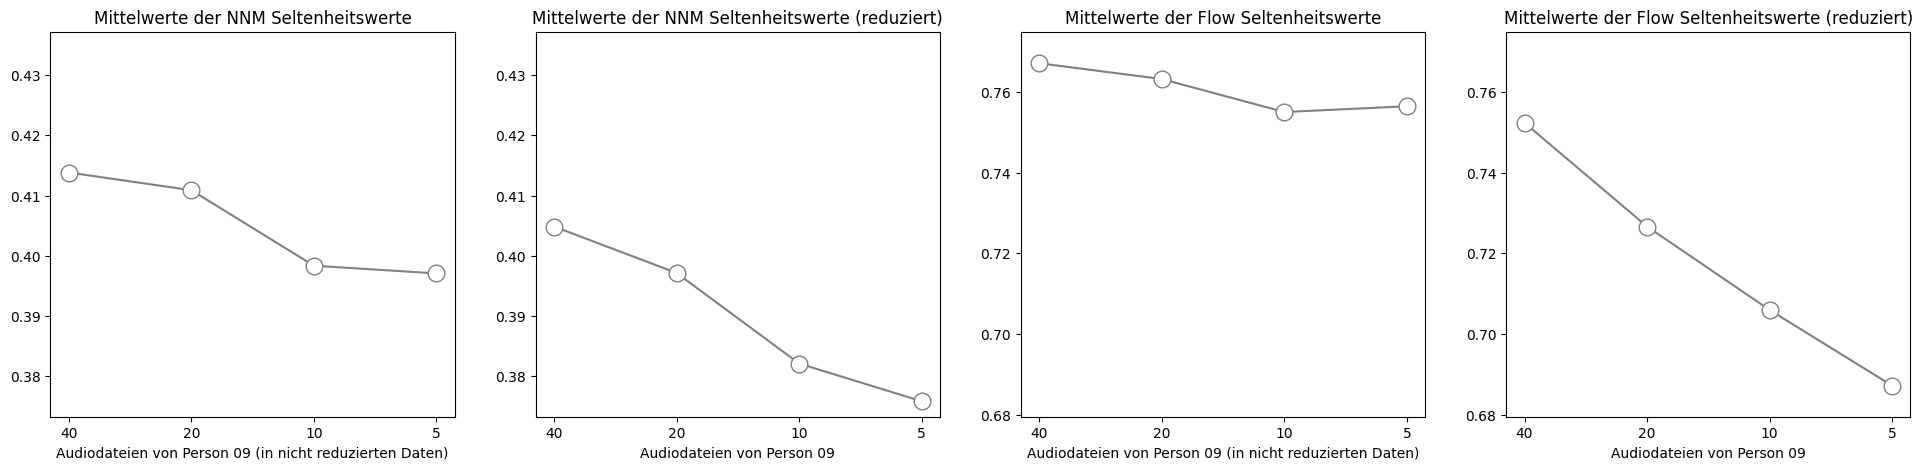

In [474]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

axs[0].plot(rarity_scores_means , color='grey', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte der NNM Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit_9)))
axs[0].set_xticklabels(examples_per_digit_9)
axs[0].set_xlabel('Audiodateien von Person 09 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_means)*0.94, max(rarity_scores_red_means)*1.08])

axs[1].plot(rarity_scores_red_means , color='grey', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte der NNM Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit_9)))
axs[1].set_xticklabels(examples_per_digit_9)
axs[1].set_xlabel('Audiodateien von Person 09')
axs[1].set_ylim([min(rarity_scores_means)*0.94, max(rarity_scores_red_means)*1.08])

axs[2].plot(rarity_scores_flow_means , color='grey', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte der Flow Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit_9)))
axs[2].set_xticklabels(examples_per_digit_9)
axs[2].set_xlabel('Audiodateien von Person 09 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_flow_means)*0.9, max(rarity_scores_red_flow_means)*1.03])

axs[3].plot(rarity_scores_red_flow_means , color='grey', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte der Flow Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit_9)))
axs[3].set_xticklabels(examples_per_digit_9)
axs[3].set_xlabel('Audiodateien von Person 09')
axs[3].set_ylim([min(rarity_scores_flow_means)*0.9, max(rarity_scores_red_flow_means)*1.03])

(0.34919787496639193, 0.5129187672414368)

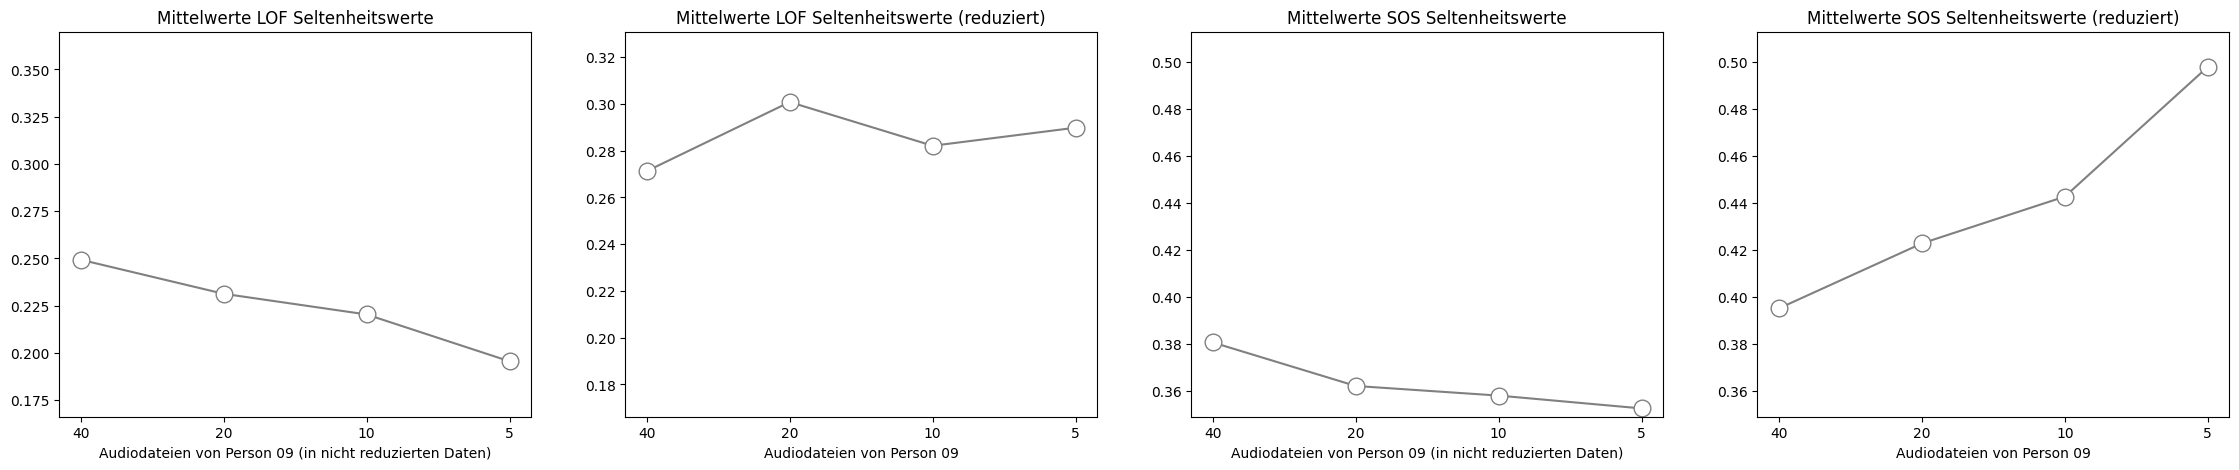

In [476]:
fig, axs = plt.subplots(1, 4, figsize=(28, 5))

axs[0].plot(rarity_scores_lof_means , color='grey', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte LOF Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit_9)))
axs[0].set_xticklabels(examples_per_digit_9)
axs[0].set_xlabel('Audiodateien von Person 09 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_lof_means)*0.85, max(rarity_scores_red_lof_means)*1.23])

axs[1].plot(rarity_scores_red_lof_means , color='grey', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte LOF Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit_9)))
axs[1].set_xticklabels(examples_per_digit_9)
axs[1].set_xlabel('Audiodateien von Person 09')
axs[1].set_ylim([min(rarity_scores_lof_means)*0.85, max(rarity_scores_red_lof_means)*1.1])

axs[2].plot(rarity_scores_sos_means , color='grey', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte SOS Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit_9)))
axs[2].set_xticklabels(examples_per_digit_9)
axs[2].set_xlabel('Audiodateien von Person 09 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_sos_means)*0.99, max(rarity_scores_red_sos_means)*1.03])

axs[3].plot(rarity_scores_red_sos_means , color='grey', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte SOS Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit_9)))
axs[3].set_xticklabels(examples_per_digit_9)
axs[3].set_xlabel('Audiodateien von Person 09')
axs[3].set_ylim([min(rarity_scores_sos_means)*0.99, max(rarity_scores_red_sos_means)*1.03])


## Multi Test: Reduziere Person 5 (gleichmässig)

In [451]:
# Beispiele pro Ziffer in Ordner (Person)
examples_per_digit_5 = [40, 20, 10, 5]

# Funktion, um Seltenheitswerte basierend auf Distanz und Anomalie-Erkennungsmodellen zu berechnen
def calculate_rarity_scores(audio_files_reduced, distances, n_neighbours=200):
    reduced_indices = [audio_files.index(file) for file in audio_files_reduced]
    distances_red = distances[np.ix_(reduced_indices, reduced_indices)]

    # N-Mean Methode
    sorted_scores = [sorted(score_array)[:n_neighbours] for score_array in distances_red]
    value_sums = [sum(score_array) for score_array in sorted_scores]
    instance_counts = [len(score_array) for score_array in sorted_scores]
    averages = [value_sum / instance_count for value_sum, instance_count in zip(value_sums, instance_counts)]

    # Normalisierung und Umkehrung
    rarityScore = averages
    min_score = min(rarityScore)
    max_score = max(rarityScore)
    rarityScore = (rarityScore - min_score) / (max_score - min_score)
    
    # Flussbasierte Seltenheitswerte
    scores_normalized = (distances_red - distances_red.min()) / (distances_red.max() - distances_red.min())
    sorted_ids = np.argsort(scores_normalized)
    n_next_hubs = 200
    inward_flow_results = np.zeros(len(scores_normalized))
    
    for id in range(len(scores_normalized)):
        idx = sorted_ids[id][1:(n_next_hubs + 1)]
        inward_flow_results[id] += np.exp(-10 * scores_normalized[id, idx]).sum()
    
    rarityScore_flow_red = 1 - inward_flow_results
    rarityScore_flow_red = (rarityScore_flow_red - np.min(rarityScore_flow_red)) / (np.max(rarityScore_flow_red) - np.min(rarityScore_flow_red))
    
    # LOF
    lof = LOF(n_neighbors=n_neighbours, novelty=True, metric='cosine')
    lof.fit(distances_red)
    rarity_score_lof = lof.decision_function(distances_red)
    rarity_score_lof = (rarity_score_lof - np.min(rarity_score_lof)) / (np.max(rarity_score_lof) - np.min(rarity_score_lof))

    # SOS
    sos = SOS(metric='euclidean', perplexity=n_neighbours)
    sos.fit(distances_red)
    outlier_scores_sos = sos.decision_function(distances_red)
    rarity_score_sos = (outlier_scores_sos - np.min(outlier_scores_sos)) / (np.max(outlier_scores_sos) - np.min(outlier_scores_sos))

    # Sampling
    sp = Sampling(subset_size=n_neighbours, contamination=0.1, metric='euclidean')
    sp.fit(distances_red)
    outlier_scores_sp = sp.decision_function(distances_red)
    rarity_score_sp = (outlier_scores_sp - np.min(outlier_scores_sp)) / (np.max(outlier_scores_sp) - np.min(outlier_scores_sp))

    return rarityScore, rarityScore_flow_red, rarity_score_lof, rarity_score_sos, rarity_score_sp, reduced_indices

# Hauptfunktion zur Reduzierung und Berechnung der Seltenheitswerte
def reduce_and_calculate_rarity(directories, examples_per_digit_5):
    rarity_scores_reduced5 = []
    rarity_scores_reduced5_flow = []
    rarity_scores_reduced5_lof = []
    rarity_scores_reduced5_sos = []
    rarity_scores_reduced5_sp = []
    audio_files_reduced_list5 = []  # Liste für audio_files_reduced
    reduced_indices_list5 = []  # Liste für reduced_indices
    
    for max_files_per_number in examples_per_digit_5:
        files_per_extracted_number = {str(i): 0 for i in range(10)}
        audio_files_reduced = []
        reduced_indices = []
        
        for directory in directories:
            directory_path = os.path.join(base_path, directory)
            for file in os.listdir(directory_path):
                if file.endswith('.wav'):
                    full_path = os.path.join(directory_path, file)
                    extracted_number = file[0] 
                    
                    if directory == "05" and files_per_extracted_number[extracted_number] < max_files_per_number:
                        audio_files_reduced.append(full_path)
                        reduced_indices.append(files_per_extracted_number[extracted_number])
                        files_per_extracted_number[extracted_number] += 1
                    elif directory != "05":
                        audio_files_reduced.append(full_path)
                        reduced_indices.append(files_per_extracted_number[extracted_number])
        
        # Berechne Seltenheitswerte für die reduzierte Liste mit verschiedenen Methoden
        scores, flow_scores, lof_scores, sos_scores, sp_scores, reduced_indices = calculate_rarity_scores(audio_files_reduced, distances)
        
        # Anstatt die Scores direkt in die Hauptliste einzufügen, fügen Sie sie zu den spezifischen Listen hinzu
        for scores, flow_scores, lof_scores, sos_scores, sp_scores, _ in [calculate_rarity_scores(audio_files_reduced, distances)]:
            rarity_scores_reduced5.append(scores)
            rarity_scores_reduced5_flow.append(flow_scores)
            rarity_scores_reduced5_lof.append(lof_scores)
            rarity_scores_reduced5_sos.append(sos_scores)
            rarity_scores_reduced5_sp.append(sp_scores)
            audio_files_reduced_list5.append(audio_files_reduced)
            reduced_indices_list5.append(reduced_indices)

    # Rückgabe der organisierten Listen
    return rarity_scores_reduced5, rarity_scores_reduced5_flow, rarity_scores_reduced5_lof, rarity_scores_reduced5_sos, rarity_scores_reduced5_sp, audio_files_reduced_list5, reduced_indices_list5

# Aufrufen der Hauptfunktion und Organisieren der Ergebnisse entsprechend
rarity_scores_reduced5, rarity_scores_reduced5_flow, rarity_scores_reduced5_lof, rarity_scores_reduced5_sos, rarity_scores_reduced5_sp, reduced_indices5, audio_files_reduced5 = reduce_and_calculate_rarity(directories, examples_per_digit_5)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWar

In [452]:
for i, scores in enumerate(rarity_scores_reduced5):
    rarity_scores_reduced5[i] = np.array(rarity_scores_reduced5[i])
    rarity_scores_reduced5_flow[i] = np.array(rarity_scores_reduced5_flow[i])
    rarity_scores_reduced5_lof[i] = np.array(rarity_scores_reduced5_lof[i])
    rarity_scores_reduced5_sos[i] = np.array(rarity_scores_reduced5_sos[i])
    rarity_scores_reduced5_sp[i] = np.array(rarity_scores_reduced5_sp[i])

In [460]:
# Indizes für Dateien aus Verzeichnis "05" extrahieren
indices_dir_05 = [index for index, file in enumerate(audio_files) if file.split('_')[1] == '05']

rarity_scores_means = []
rarity_scores_red_means = []
rarity_scores_flow_means = []
rarity_scores_red_flow_means = []
rarity_scores_lof_means = []
rarity_scores_red_lof_means = []
rarity_scores_sos_means = []
rarity_scores_red_sos_means = []
rarity_scores_sp_means = []
rarity_scores_red_sp_means = []

# Mittelwert Loop
for i, (scores, scores_flow, scores_lof, scores_sos, scores_sp) in enumerate(zip(rarity_scores_reduced5, rarity_scores_reduced5_flow, rarity_scores_reduced5_lof, rarity_scores_reduced5_sos, rarity_scores_reduced5_sp)):
    indices_dir_05_red = [index for index, file in enumerate(audio_files) if file.split('_')[1] == '05' and index in audio_files_reduced5[i]]
    indices_dir_05_complete = [index for index, file in enumerate(reduced_indices5[i]) if file.split('_')[1] == '05']
    
    # Filtern der Daten für Verzeichnis 05
    filtered_rarity_score = rarityScore[indices_dir_05_complete]
    filtered_rarity_score_red = scores[indices_dir_05_red]

    filtered_rarity_score_flow = rarityScore_flow[indices_dir_05_complete]
    filtered_rarity_score_red_flow = scores_flow[indices_dir_05_red]
    
    filtered_rarity_score_lof = rarity_score_lof[indices_dir_05_complete]
    filtered_rarity_score_red_lof = scores_lof[indices_dir_05_red]
        
    filtered_rarity_score_sos = rarity_score_sos[indices_dir_05_complete]
    filtered_rarity_score_red_sos = scores_sos[indices_dir_05_red]

    filtered_rarity_score_sp = rarity_score_sp[indices_dir_05_complete]
    filtered_rarity_score_red_sp = scores_sp[indices_dir_05_red]

    # Berechne Mittelwert
    rarity_scores_means.append(filtered_rarity_score.mean())
    rarity_scores_red_means.append(filtered_rarity_score_red.mean())

    rarity_scores_flow_means.append(filtered_rarity_score_flow.mean())
    rarity_scores_red_flow_means.append(filtered_rarity_score_red_flow.mean())

    rarity_scores_lof_means.append(filtered_rarity_score_lof.mean())
    rarity_scores_red_lof_means.append(filtered_rarity_score_red_lof.mean())

    rarity_scores_sos_means.append(filtered_rarity_score_sos.mean())
    rarity_scores_red_sos_means.append(filtered_rarity_score_red_sos.mean())

    rarity_scores_sp_means.append(filtered_rarity_score_sp.mean())
    rarity_scores_red_sp_means.append(filtered_rarity_score_red_sp.mean())

print(rarity_scores_means, '\n ', rarity_scores_red_means ,'\n ' ,rarity_scores_flow_means , '\n ', rarity_scores_red_flow_means, '\n ' ,rarity_scores_lof_means , '\n ', rarity_scores_red_lof_means, '\n ' ,rarity_scores_sos_means , '\n ', rarity_scores_red_sos_means, '\n ' ,rarity_scores_sp_means , '\n ', rarity_scores_red_sp_means)



[0.07726612732432818, 0.07550540256659785, 0.06530942777547169, 0.06490282912290349] 
  [0.08090881829643605, 0.08102993691747117, 0.10480597233705494, 0.0898570114370397] 
  [0.23661011808582144, 0.22980576159463595, 0.20530236793904647, 0.2033602375527163] 
  [0.24601049609899994, 0.25056175522996604, 0.3034725924040238, 0.27647684798472555] 
  [0.03032403114115352, 0.02681001265026398, 0.02229039494244765, 0.02271474829164866] 
  [0.03409309459328596, 0.030411526258534077, 0.05797841885064431, 0.036861523670659264] 
  [0.18119379435482372, 0.16846055594080994, 0.15267232404040085, 0.146592205244607] 
  [0.19240597631482845, 0.18788838933404176, 0.22257958718368287, 0.18787346380575654] 
  [0.07794073072220971, 0.07462072853076446, 0.0695818184493024, 0.06919699792512829] 
  [0.12660307768982984, 0.13195585196799223, 0.1149912491173416, 0.06973716946397727]


(0.18302421379744466, 0.31257677017614455)

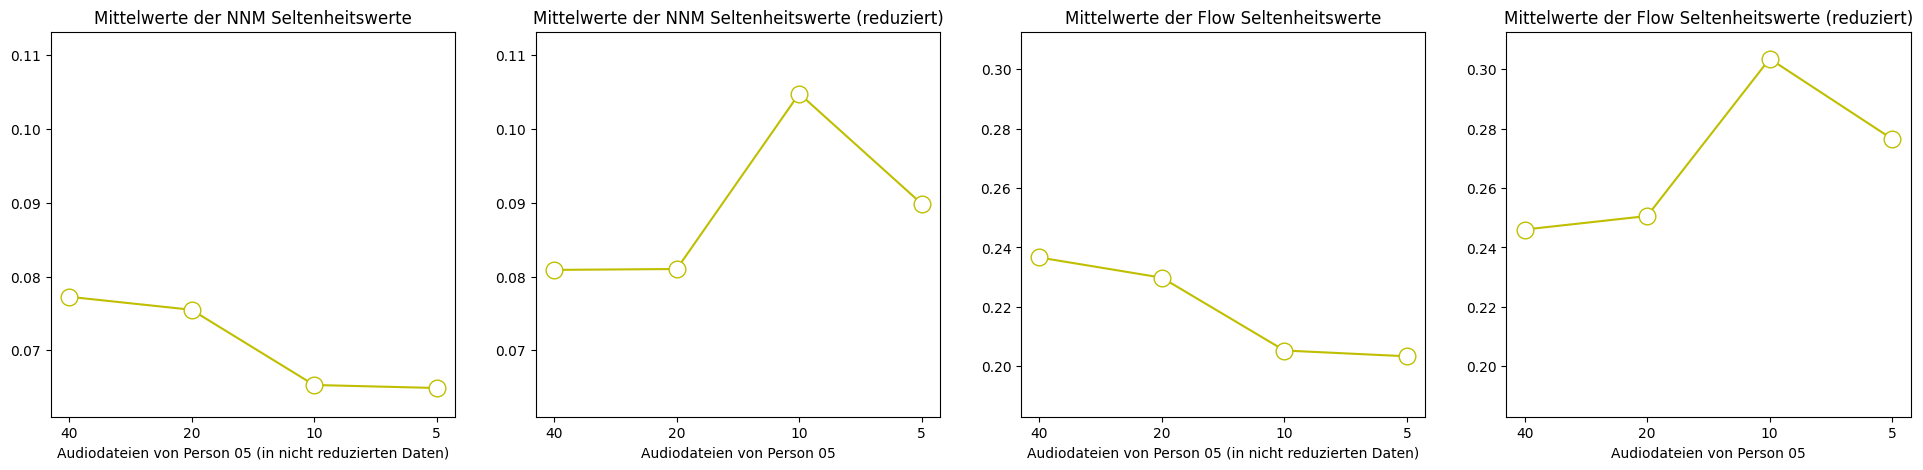

In [461]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

axs[0].plot(rarity_scores_means , color='y', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte der NNM Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit_5)))
axs[0].set_xticklabels(examples_per_digit_5)
axs[0].set_xlabel('Audiodateien von Person 05 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_means)*0.94, max(rarity_scores_red_means)*1.08])

axs[1].plot(rarity_scores_red_means , color='y', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte der NNM Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit_5)))
axs[1].set_xticklabels(examples_per_digit_5)
axs[1].set_xlabel('Audiodateien von Person 05')
axs[1].set_ylim([min(rarity_scores_means)*0.94, max(rarity_scores_red_means)*1.08])

axs[2].plot(rarity_scores_flow_means , color='y', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte der Flow Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit_5)))
axs[2].set_xticklabels(examples_per_digit_5)
axs[2].set_xlabel('Audiodateien von Person 05 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_flow_means)*0.9, max(rarity_scores_red_flow_means)*1.03])

axs[3].plot(rarity_scores_red_flow_means , color='y', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte der Flow Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit_5)))
axs[3].set_xticklabels(examples_per_digit_5)
axs[3].set_xlabel('Audiodateien von Person 05')
axs[3].set_ylim([min(rarity_scores_flow_means)*0.9, max(rarity_scores_red_flow_means)*1.03])

(0.14512628319216092, 0.22925697479919335)

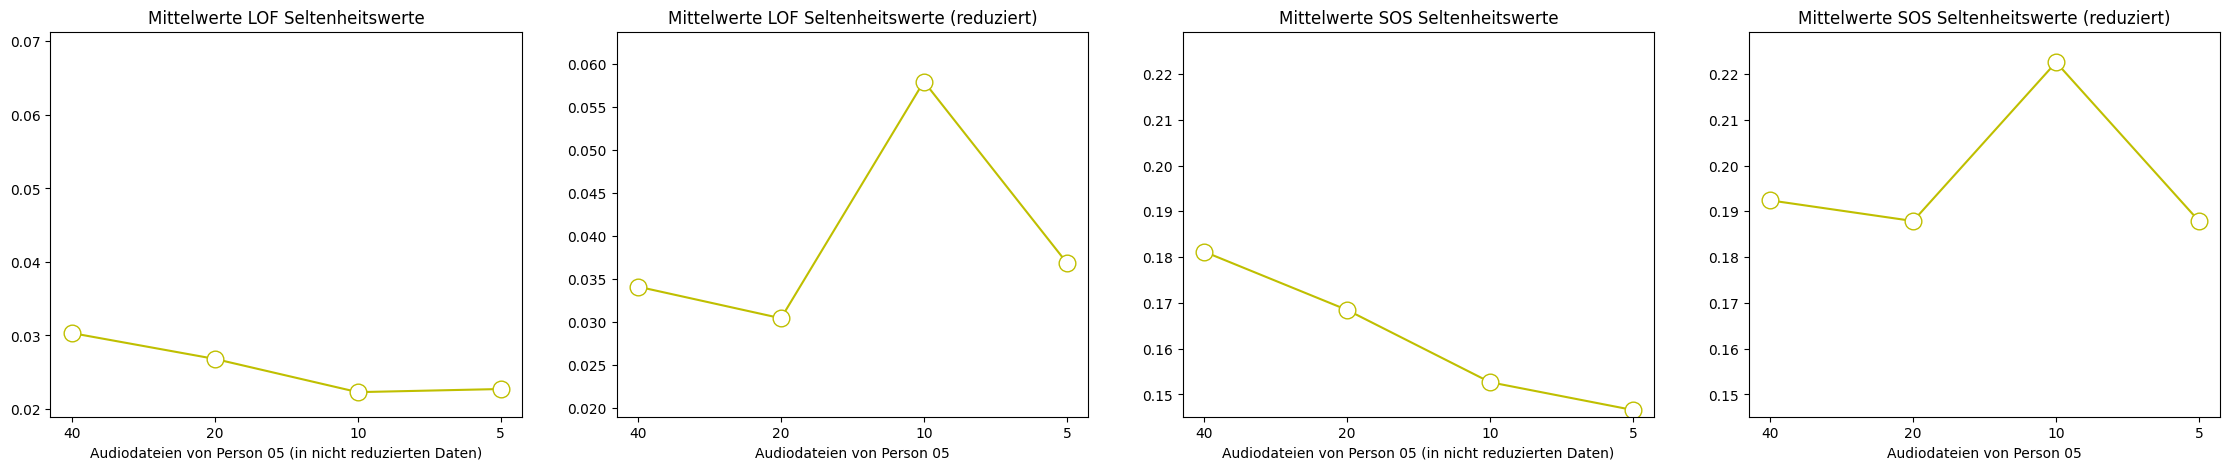

In [462]:
fig, axs = plt.subplots(1, 4, figsize=(28, 5))

axs[0].plot(rarity_scores_lof_means , color='y', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte LOF Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit_5)))
axs[0].set_xticklabels(examples_per_digit_5)
axs[0].set_xlabel('Audiodateien von Person 05 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_lof_means)*0.85, max(rarity_scores_red_lof_means)*1.23])

axs[1].plot(rarity_scores_red_lof_means , color='y', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte LOF Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit_5)))
axs[1].set_xticklabels(examples_per_digit_5)
axs[1].set_xlabel('Audiodateien von Person 05')
axs[1].set_ylim([min(rarity_scores_lof_means)*0.85, max(rarity_scores_red_lof_means)*1.1])

axs[2].plot(rarity_scores_sos_means , color='y', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte SOS Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit_5)))
axs[2].set_xticklabels(examples_per_digit_5)
axs[2].set_xlabel('Audiodateien von Person 05 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_sos_means)*0.99, max(rarity_scores_red_sos_means)*1.03])

axs[3].plot(rarity_scores_red_sos_means , color='y', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte SOS Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit_5)))
axs[3].set_xticklabels(examples_per_digit_5)
axs[3].set_xlabel('Audiodateien von Person 05')
axs[3].set_ylim([min(rarity_scores_sos_means)*0.99, max(rarity_scores_red_sos_means)*1.03])

## Multi Test: Reduziere Ziffer 2

In [493]:
# Funktion, um verschiedene Arten von Seltenheitswerten zu berechnen
def calculate_rarity_scores(audio_files_reduced, distances, n_neighbours=200):
    # Erstelle eine neue Distanzmatrix, die nur die kombinierten Dateien berücksichtigt
    reduced_indices = [audio_files.index(file) for file in audio_files_reduced]
    distances_red = distances[np.ix_(reduced_indices, reduced_indices)]

    # N-Mean Methode
    sorted_scores = [sorted(score_array)[:n_neighbours] for score_array in distances_red]
    value_sums = [sum(score_array) for score_array in sorted_scores]
    instance_counts = [len(score_array) for score_array in sorted_scores]
    averages = [value_sum / instance_count for value_sum, instance_count in zip(value_sums, instance_counts)]

    # Normalisierung und Umkehrung
    rarityScore = averages
    min_score = min(rarityScore)
    max_score = max(rarityScore)
    rarityScore = (rarityScore - min_score) / (max_score - min_score)
    
    # Flussbasierte Seltenheitswerte
    scores_normalized = (distances_red - distances_red.min()) / (distances_red.max() - distances_red.min())
    sorted_ids = np.argsort(scores_normalized)
    n_next_hubs = n_neighbours
    inward_flow_results = np.zeros(len(scores_normalized))
    
    for id in range(len(scores_normalized)):
        idx = sorted_ids[id][1:(n_next_hubs + 1)]
        inward_flow_results[id] += np.exp(-10 * scores_normalized[id, idx]).sum()
    
    rarityScore_flow_red = 1 - inward_flow_results
    rarityScore_flow_red = (rarityScore_flow_red - np.min(rarityScore_flow_red)) / (np.max(rarityScore_flow_red) - np.min(rarityScore_flow_red))
    
    # LOF
    lof = LOF(n_neighbors=n_neighbours, novelty=True, metric='cosine')
    lof.fit(distances_red)
    rarity_score_lof = lof.decision_function(distances_red)
    rarity_score_lof = (rarity_score_lof - np.min(rarity_score_lof)) / (np.max(rarity_score_lof) - np.min(rarity_score_lof))

    # SOS
    sos = SOS(metric='euclidean', perplexity=n_neighbours)
    sos.fit(distances_red)
    outlier_scores_sos = sos.decision_function(distances_red)
    rarity_score_sos = (outlier_scores_sos - np.min(outlier_scores_sos)) / (np.max(outlier_scores_sos) - np.min(outlier_scores_sos))

    # Sampling
    sp = Sampling(subset_size=n_neighbours, contamination=0.1, metric='euclidean')
    sp.fit(distances_red)
    outlier_scores_sp = sp.decision_function(distances_red)
    rarity_score_sp = (outlier_scores_sp - np.min(outlier_scores_sp)) / (np.max(outlier_scores_sp) - np.min(outlier_scores_sp))

    # Rückgabe aller fünf Seltenheitswertarten
    return rarityScore, rarityScore_flow_red, rarity_score_lof, rarity_score_sos, rarity_score_sp, reduced_indices

# Hauptfunktion zur Reduzierung und Berechnung der Seltenheitswerte
def reduce_and_calculate_rarity_for_digit_two(examples_per_digit_2, audio_files, distances, extracted_numbers):
    # Initialisiere Listen für jeden Seltenheitswerttyp und für reduzierte Dateien und Indizes
    rarity_scores_reduced2 = []
    rarity_scores_reduced2_flow = []
    rarity_scores_reduced2_lof = []
    rarity_scores_reduced2_sos = []
    rarity_scores_reduced2_sp = []
    reduced_indices_list = []  # Liste für reduced_indices

    for max_files in examples_per_digit_2:
        # Selektiere Dateien für die Ziffer 2 bis zum gewünschten Limit
        label_2_files = [file for file, label in zip(audio_files, extracted_numbers) if label == 2][:max_files]
        # Behalte alle Dateien, die nicht zur Ziffer 2 gehören
        non_label_2_files = [file for file, label in zip(audio_files, extracted_numbers) if label != 2]
        # Kombiniere die Dateilisten
        combined_files = label_2_files + non_label_2_files

        # Liste für die extrahierten Zahlen
        extracted_numbers_red = []



        # Berechne die Seltenheitswerte für die reduzierte Dateiliste
        #scores, flow_scores, lof_scores, sos_scores, sp_scores, reduced_indices = calculate_rarity_scores(combined_files, distances, n_neighbours=200)

        # Anstatt die Scores direkt in die Hauptliste einzufügen, fügen Sie sie zu den spezifischen Listen hinzu
        for scores, flow_scores, lof_scores, sos_scores, sp_scores, _ in [calculate_rarity_scores(combined_files, distances)]:
            rarity_scores_reduced2.append(scores)
            rarity_scores_reduced2_flow.append(flow_scores)
            rarity_scores_reduced2_lof.append(lof_scores)
            rarity_scores_reduced2_sos.append(sos_scores)
            rarity_scores_reduced2_sp.append(sp_scores)
            reduced_indices_list.append(reduced_indices)

            for file in combined_files:
                # Trenne den Dateinamen an den Unterstrichen
                parts = file.split('_')
                # Extrahiere die erste Zahl (als String) und konvertiere sie in ein Integer
                number = int(parts[0].split('/')[-1])
                # Füge die Zahl zur Liste hininzu
                extracted_numbers_red.append(number)

    # Rückgabe der organisierten Listen mit Seltenheitswerten sowie der Listen reduzierter Dateien und Indizes
    return rarity_scores_reduced2, rarity_scores_reduced2_flow, rarity_scores_reduced2_lof, rarity_scores_reduced2_sos, rarity_scores_reduced2_sp, reduced_indices_list, extracted_numbers_red

# Anzahl der Beispiele, die für die Ziffer 2 reduziert werden sollen
examples_per_digit_2 = [700, 500, 250, 100, 50, 10]

# Aufruf der Hauptfunktion und Organisieren der Ergebnisse entsprechend
rarity_scores_reduced2, rarity_scores_reduced2_flow, rarity_scores_reduced2_lof, rarity_scores_reduced2_sos, rarity_scores_reduced2_sp, reduced_indices_list, extracted_numbers_red = reduce_and_calculate_rarity_for_digit_two(examples_per_digit_2, audio_files, distances, extracted_numbers)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWar

In [494]:
for i, scores in enumerate(rarity_scores_reduced2):
    rarity_scores_reduced2[i] = np.array(rarity_scores_reduced2[i])
    rarity_scores_reduced2_flow[i] = np.array(rarity_scores_reduced2_flow[i])
    rarity_scores_reduced2_lof[i] = np.array(rarity_scores_reduced2_lof[i])
    rarity_scores_reduced2_sos[i] = np.array(rarity_scores_reduced2_sos[i])
    rarity_scores_reduced2_sp[i] = np.array(rarity_scores_reduced2_sp[i])

In [495]:
examples_per_digit_2[1]

500

In [496]:
# Labels definieren
labels = extracted_numbers


rarity_scores_means = []
rarity_scores_red_means = []
rarity_scores_flow_means = []
rarity_scores_red_flow_means = []
rarity_scores_lof_means = []
rarity_scores_red_lof_means = []
rarity_scores_sos_means = []
rarity_scores_red_sos_means = []
rarity_scores_sp_means = []
rarity_scores_red_sp_means = []


# Mittelwert Loop
for i, (scores, scores_flow, scores_lof, scores_sos, scores_sp) in enumerate(zip(rarity_scores_reduced2, rarity_scores_reduced2_flow, rarity_scores_reduced2_lof, rarity_scores_reduced2_sos, rarity_scores_reduced2_sp)):
    if i < 6:
        labels_reduced = extracted_numbers_red[i]
        filtered_indices = [index for index, value in enumerate(extracted_numbers) if value == 2]
        filtered_indices_red = [index for index, value in enumerate(extracted_numbers_red) if value == 2]
        filtered_numbers = [examples_per_digit_2[i]]

        # Filtern der Daten für Verzeichnis 12
        filtered_rarity_score = rarityScore[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red = scores[filtered_indices_red]

        filtered_rarity_score_flow = rarityScore_flow[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red_flow = scores_flow[filtered_indices_red]
        
        filtered_rarity_score_lof = rarity_score_lof[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red_lof = scores_lof[filtered_indices_red]
            
        filtered_rarity_score_sos = rarity_score_sos[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red_sos = scores_sos[filtered_indices_red]

        filtered_rarity_score_sp = rarity_score_sp[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red_sp = scores_sp[filtered_indices_red]

        # Berechne Mittelwert
        rarity_scores_means.append(filtered_rarity_score.mean())
        rarity_scores_red_means.append(filtered_rarity_score_red.mean())

        rarity_scores_flow_means.append(filtered_rarity_score_flow.mean())
        rarity_scores_red_flow_means.append(filtered_rarity_score_red_flow.mean())

        rarity_scores_lof_means.append(filtered_rarity_score_lof.mean())
        rarity_scores_red_lof_means.append(filtered_rarity_score_red_lof.mean())

        rarity_scores_sos_means.append(filtered_rarity_score_sos.mean())
        rarity_scores_red_sos_means.append(filtered_rarity_score_red_sos.mean())

        rarity_scores_sp_means.append(filtered_rarity_score_sp.mean())
        rarity_scores_red_sp_means.append(filtered_rarity_score_red_sp.mean())

print(rarity_scores_means, '\n ', rarity_scores_red_means ,'\n ' ,rarity_scores_flow_means , '\n ', rarity_scores_red_flow_means, '\n ' ,rarity_scores_lof_means , '\n ', rarity_scores_red_lof_means, '\n ' ,rarity_scores_sos_means , '\n ', rarity_scores_red_sos_means, '\n ' ,rarity_scores_sp_means , '\n ', rarity_scores_red_sp_means)



[0.09279353668123735, 0.10413885989870902, 0.06877905774234849, 0.06818171852903276, 0.08322827729947972, 0.07126035324769898] 
  [0.07776541414844428, 0.08351908379959629, 0.08867996974245011, 0.10059412263760523, 0.10416764530564686, 0.10879244830584396] 
  [0.26710589201153506, 0.29387868886067986, 0.20851257315102412, 0.20765647967903061, 0.24734689365093881, 0.22632615877003123] 
  [0.2526577291989563, 0.27009686550964274, 0.28508911102763157, 0.3208830695742355, 0.33134908669244306, 0.3454778076187391] 
  [0.055309634095803153, 0.07060214617144153, 0.03268143669523695, 0.0341600342257969, 0.04086304484335521, 0.04155241875745612] 
  [0.04069099046334182, 0.03888210797561057, 0.03526872978429347, 0.03524504819403704, 0.03511565733522777, 0.03468102983805662] 
  [0.23849394167384008, 0.2730205228546344, 0.24055506705805627, 0.24120727940313194, 0.24642841052590675, 0.2547751770175596] 
  [0.25751020470651576, 0.2563358184901813, 0.26114006766087483, 0.27377263669937213, 0.275424393

(0.20350335008545, 0.3558421418473013)

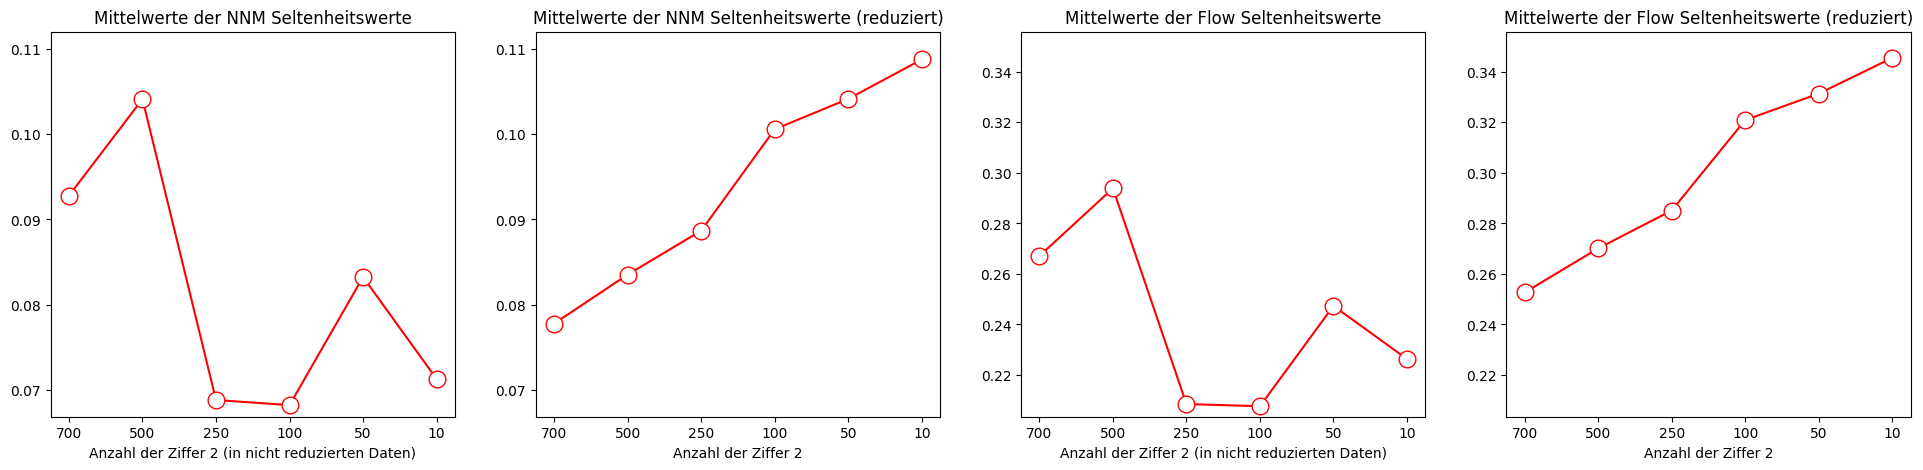

In [497]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

axs[0].plot(rarity_scores_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte der NNM Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit_2)))
axs[0].set_xticklabels(examples_per_digit_2)
axs[0].set_xlabel('Anzahl der Ziffer 2 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_means)*0.98, max(rarity_scores_red_means)*1.03])

axs[1].plot(rarity_scores_red_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte der NNM Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit_2)))
axs[1].set_xticklabels(examples_per_digit_2)
axs[1].set_xlabel('Anzahl der Ziffer 2')
axs[1].set_ylim([min(rarity_scores_means)*0.98, max(rarity_scores_red_means)*1.03])

axs[2].plot(rarity_scores_flow_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte der Flow Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit_2)))
axs[2].set_xticklabels(examples_per_digit_2)
axs[2].set_xlabel('Anzahl der Ziffer 2 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_flow_means)*0.98, max(rarity_scores_red_flow_means)*1.03])

axs[3].plot(rarity_scores_red_flow_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte der Flow Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit_2)))
axs[3].set_xticklabels(examples_per_digit_2)
axs[3].set_xlabel('Anzahl der Ziffer 2')
axs[3].set_ylim([min(rarity_scores_flow_means)*0.98, max(rarity_scores_red_flow_means)*1.03])

(0.2337240628403633, 0.29086308347755596)

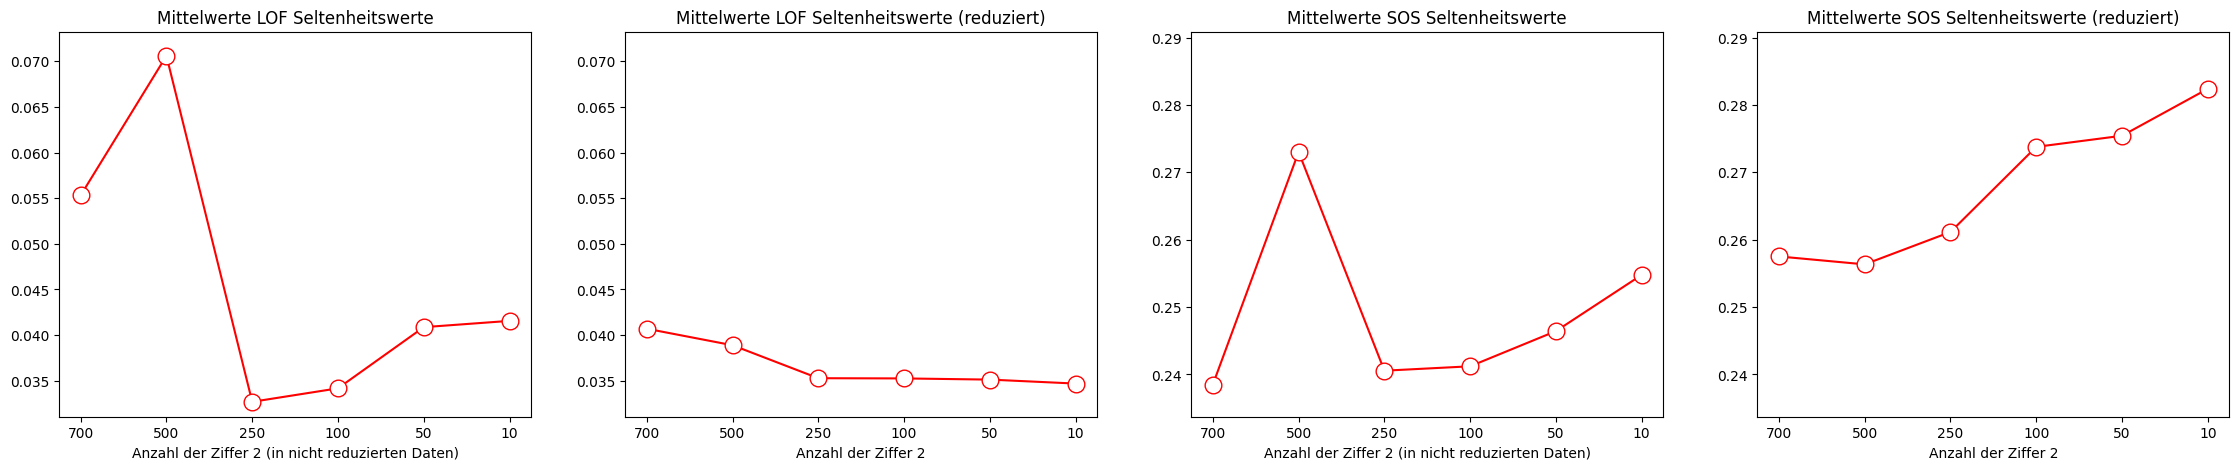

In [498]:
fig, axs = plt.subplots(1, 4, figsize=(28, 5))

axs[0].plot(rarity_scores_lof_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte LOF Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit_2)))
axs[0].set_xticklabels(examples_per_digit_2)
axs[0].set_xlabel('Anzahl der Ziffer 2 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_lof_means)*0.95, max(rarity_scores_red_lof_means)*1.8])

axs[1].plot(rarity_scores_red_lof_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte LOF Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit_2)))
axs[1].set_xticklabels(examples_per_digit_2)
axs[1].set_xlabel('Anzahl der Ziffer 2')
axs[1].set_ylim([min(rarity_scores_lof_means)*0.95, max(rarity_scores_red_lof_means)*1.8])

axs[2].plot(rarity_scores_sos_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte SOS Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit_2)))
axs[2].set_xticklabels(examples_per_digit_2)
axs[2].set_xlabel('Anzahl der Ziffer 2 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_sos_means)*0.98, max(rarity_scores_red_sos_means)*1.03])

axs[3].plot(rarity_scores_red_sos_means , color='r', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte SOS Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit_2)))
axs[3].set_xticklabels(examples_per_digit_2)
axs[3].set_xlabel('Anzahl der Ziffer 2')
axs[3].set_ylim([min(rarity_scores_sos_means)*0.98, max(rarity_scores_red_sos_means)*1.03])

## Multi Test: Reduziere Ziffer 6

In [499]:
# Funktion, um verschiedene Arten von Seltenheitswerten zu berechnen
def calculate_rarity_scores(audio_files_reduced, distances, n_neighbours=200):
    # Erstelle eine neue Distanzmatrix, die nur die kombinierten Dateien berücksichtigt
    reduced_indices = [audio_files.index(file) for file in audio_files_reduced]
    distances_red = distances[np.ix_(reduced_indices, reduced_indices)]

    # N-Mean Methode
    sorted_scores = [sorted(score_array)[:n_neighbours] for score_array in distances_red]
    value_sums = [sum(score_array) for score_array in sorted_scores]
    instance_counts = [len(score_array) for score_array in sorted_scores]
    averages = [value_sum / instance_count for value_sum, instance_count in zip(value_sums, instance_counts)]

    # Normalisierung und Umkehrung
    rarityScore = averages
    min_score = min(rarityScore)
    max_score = max(rarityScore)
    rarityScore = (rarityScore - min_score) / (max_score - min_score)
    
    # Flussbasierte Seltenheitswerte
    scores_normalized = (distances_red - distances_red.min()) / (distances_red.max() - distances_red.min())
    sorted_ids = np.argsort(scores_normalized)
    n_next_hubs = n_neighbours
    inward_flow_results = np.zeros(len(scores_normalized))
    
    for id in range(len(scores_normalized)):
        idx = sorted_ids[id][1:(n_next_hubs + 1)]
        inward_flow_results[id] += np.exp(-10 * scores_normalized[id, idx]).sum()
    
    rarityScore_flow_red = 1 - inward_flow_results
    rarityScore_flow_red = (rarityScore_flow_red - np.min(rarityScore_flow_red)) / (np.max(rarityScore_flow_red) - np.min(rarityScore_flow_red))
    
    # LOF
    lof = LOF(n_neighbors=n_neighbours, novelty=True, metric='cosine')
    lof.fit(distances_red)
    rarity_score_lof = lof.decision_function(distances_red)
    rarity_score_lof = (rarity_score_lof - np.min(rarity_score_lof)) / (np.max(rarity_score_lof) - np.min(rarity_score_lof))

    # SOS
    sos = SOS(metric='euclidean', perplexity=n_neighbours)
    sos.fit(distances_red)
    outlier_scores_sos = sos.decision_function(distances_red)
    rarity_score_sos = (outlier_scores_sos - np.min(outlier_scores_sos)) / (np.max(outlier_scores_sos) - np.min(outlier_scores_sos))

    # Sampling
    sp = Sampling(subset_size=n_neighbours, contamination=0.1, metric='euclidean')
    sp.fit(distances_red)
    outlier_scores_sp = sp.decision_function(distances_red)
    rarity_score_sp = (outlier_scores_sp - np.min(outlier_scores_sp)) / (np.max(outlier_scores_sp) - np.min(outlier_scores_sp))

    # Rückgabe aller fünf Seltenheitswertarten
    return rarityScore, rarityScore_flow_red, rarity_score_lof, rarity_score_sos, rarity_score_sp, reduced_indices

# Hauptfunktion zur Reduzierung und Berechnung der Seltenheitswerte
def reduce_and_calculate_rarity_for_digit_two(examples_per_digit_6, audio_files, distances, extracted_numbers):
    # Initialisiere Listen für jeden Seltenheitswerttyp und für reduzierte Dateien und Indizes
    rarity_scores_reduced6 = []
    rarity_scores_reduced6_flow = []
    rarity_scores_reduced6_lof = []
    rarity_scores_reduced6_sos = []
    rarity_scores_reduced6_sp = []
    reduced_indices_list = []  # Liste für reduced_indices

    for max_files in examples_per_digit_6:
        # Selektiere Dateien für die Ziffer 6 bis zum gewünschten Limit
        label_6_files = [file for file, label in zip(audio_files, extracted_numbers) if label == 6][:max_files]
        # Behalte alle Dateien, die nicht zur Ziffer 2 gehören
        non_label_6_files = [file for file, label in zip(audio_files, extracted_numbers) if label != 6]
        # Kombiniere die Dateilisten
        combined_files = label_6_files + non_label_6_files

        # Liste für die extrahierten Zahlen
        extracted_numbers_red6 = []



        # Berechne die Seltenheitswerte für die reduzierte Dateiliste
        #scores, flow_scores, lof_scores, sos_scores, sp_scores, reduced_indices = calculate_rarity_scores(combined_files, distances, n_neighbours=200)

        # Anstatt die Scores direkt in die Hauptliste einzufügen, fügen Sie sie zu den spezifischen Listen hinzu
        for scores, flow_scores, lof_scores, sos_scores, sp_scores, _ in [calculate_rarity_scores(combined_files, distances)]:
            rarity_scores_reduced6.append(scores)
            rarity_scores_reduced6_flow.append(flow_scores)
            rarity_scores_reduced6_lof.append(lof_scores)
            rarity_scores_reduced6_sos.append(sos_scores)
            rarity_scores_reduced6_sp.append(sp_scores)
            reduced_indices_list.append(reduced_indices)

            for file in combined_files:
                # Trenne den Dateinamen an den Unterstrichen
                parts = file.split('_')
                # Extrahiere die erste Zahl (als String) und konvertiere sie in ein Integer
                number = int(parts[0].split('/')[-1])
                # Füge die Zahl zur Liste hininzu
                extracted_numbers_red6.append(number)

    # Rückgabe der organisierten Listen mit Seltenheitswerten sowie der Listen reduzierter Dateien und Indizes
    return rarity_scores_reduced6, rarity_scores_reduced6_flow, rarity_scores_reduced6_lof, rarity_scores_reduced6_sos, rarity_scores_reduced6_sp, reduced_indices_list, extracted_numbers_red6

# Anzahl der Beispiele, die für die Ziffer 2 reduziert werden sollen
examples_per_digit_6 = [700, 500, 250, 100, 50, 10]

# Aufruf der Hauptfunktion und Organisieren der Ergebnisse entsprechend
rarity_scores_reduced6, rarity_scores_reduced6_flow, rarity_scores_reduced6_lof, rarity_scores_reduced6_sos, rarity_scores_reduced6_sp, reduced_indices_list, extracted_numbers_red6 = reduce_and_calculate_rarity_for_digit_two(examples_per_digit_6, audio_files, distances, extracted_numbers)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWar

In [500]:
for i, scores in enumerate(rarity_scores_reduced6):
    rarity_scores_reduced6[i] = np.array(rarity_scores_reduced6[i])
    rarity_scores_reduced6_flow[i] = np.array(rarity_scores_reduced6_flow[i])
    rarity_scores_reduced6_lof[i] = np.array(rarity_scores_reduced6_lof[i])
    rarity_scores_reduced6_sos[i] = np.array(rarity_scores_reduced6_sos[i])
    rarity_scores_reduced6_sp[i] = np.array(rarity_scores_reduced6_sp[i])

In [501]:
# Labels definieren
labels = extracted_numbers


rarity_scores_means = []
rarity_scores_red_means = []
rarity_scores_flow_means = []
rarity_scores_red_flow_means = []
rarity_scores_lof_means = []
rarity_scores_red_lof_means = []
rarity_scores_sos_means = []
rarity_scores_red_sos_means = []
rarity_scores_sp_means = []
rarity_scores_red_sp_means = []


# Mittelwert Loop
for i, (scores, scores_flow, scores_lof, scores_sos, scores_sp) in enumerate(zip(rarity_scores_reduced6, rarity_scores_reduced6_flow, rarity_scores_reduced6_lof, rarity_scores_reduced6_sos, rarity_scores_reduced6_sp)):
    if i < 6:
        labels_reduced = extracted_numbers_red6[i]
        filtered_indices = [index for index, value in enumerate(extracted_numbers) if value == 6]
        filtered_indices_red = [index for index, value in enumerate(extracted_numbers_red6) if value == 6]
        filtered_numbers = [examples_per_digit_6[i]]

        # Filtern der Daten für Verzeichnis 12
        filtered_rarity_score = rarityScore[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red = scores[filtered_indices_red]

        filtered_rarity_score_flow = rarityScore_flow[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red_flow = scores_flow[filtered_indices_red]
        
        filtered_rarity_score_lof = rarity_score_lof[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red_lof = scores_lof[filtered_indices_red]
            
        filtered_rarity_score_sos = rarity_score_sos[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red_sos = scores_sos[filtered_indices_red]

        filtered_rarity_score_sp = rarity_score_sp[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red_sp = scores_sp[filtered_indices_red]

        # Berechne Mittelwert
        rarity_scores_means.append(filtered_rarity_score.mean())
        rarity_scores_red_means.append(filtered_rarity_score_red.mean())

        rarity_scores_flow_means.append(filtered_rarity_score_flow.mean())
        rarity_scores_red_flow_means.append(filtered_rarity_score_red_flow.mean())

        rarity_scores_lof_means.append(filtered_rarity_score_lof.mean())
        rarity_scores_red_lof_means.append(filtered_rarity_score_red_lof.mean())

        rarity_scores_sos_means.append(filtered_rarity_score_sos.mean())
        rarity_scores_red_sos_means.append(filtered_rarity_score_red_sos.mean())

        rarity_scores_sp_means.append(filtered_rarity_score_sp.mean())
        rarity_scores_red_sp_means.append(filtered_rarity_score_red_sp.mean())

print(rarity_scores_means, '\n ', rarity_scores_red_means ,'\n ' ,rarity_scores_flow_means , '\n ', rarity_scores_red_flow_means, '\n ' ,rarity_scores_lof_means , '\n ', rarity_scores_red_lof_means, '\n ' ,rarity_scores_sos_means , '\n ', rarity_scores_red_sos_means, '\n ' ,rarity_scores_sp_means , '\n ', rarity_scores_red_sp_means)



[0.2603244095512579, 0.25110538630290663, 0.21244144919494923, 0.21315999908776218, 0.2106211141815357, 0.21195715427440281] 
  [0.2504214850549194, 0.25816893136414965, 0.27784672356075063, 0.29410228127475835, 0.3124232720368205, 0.3295664405872286] 
  [0.5882679238852924, 0.5761414379628546, 0.5354666081942814, 0.5348698264939487, 0.5352958947334335, 0.539305530415569] 
  [0.5953188448691866, 0.619693318207584, 0.6498859220233029, 0.677403029535893, 0.705927200824899, 0.7347430117988084] 
  [0.08042723528195808, 0.08385831909834343, 0.061410675858195374, 0.05163321991584299, 0.054382901395177326, 0.04281331285828861] 
  [0.08225013041758229, 0.10536123661264188, 0.14215669777897397, 0.17541831589336165, 0.20742469778027323, 0.22638545418623984] 
  [0.2867867365584548, 0.2896747421880315, 0.23601962376777022, 0.1874411455783376, 0.19765108219792643, 0.17095680691102727] 
  [0.2068869007775958, 0.23629698985768477, 0.26838872092875954, 0.30957114253589857, 0.34945792597877173, 0.45024

(0.5241724299640697, 0.7567853021527727)

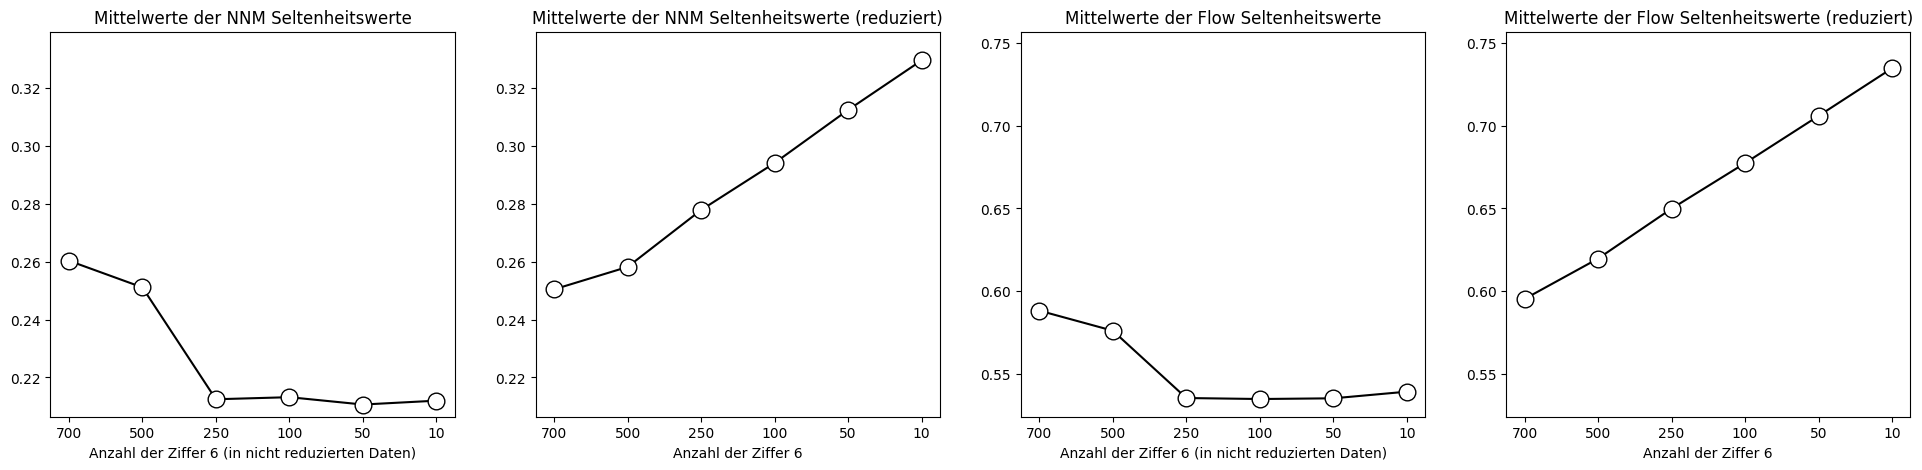

In [502]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

axs[0].plot(rarity_scores_means , color='black', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte der NNM Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit_6)))
axs[0].set_xticklabels(examples_per_digit_6)
axs[0].set_xlabel('Anzahl der Ziffer 6 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_means)*0.98, max(rarity_scores_red_means)*1.03])

axs[1].plot(rarity_scores_red_means , color='black', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte der NNM Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit_6)))
axs[1].set_xticklabels(examples_per_digit_6)
axs[1].set_xlabel('Anzahl der Ziffer 6')
axs[1].set_ylim([min(rarity_scores_means)*0.98, max(rarity_scores_red_means)*1.03])

axs[2].plot(rarity_scores_flow_means , color='black', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte der Flow Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit_6)))
axs[2].set_xticklabels(examples_per_digit_6)
axs[2].set_xlabel('Anzahl der Ziffer 6 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_flow_means)*0.98, max(rarity_scores_red_flow_means)*1.03])

axs[3].plot(rarity_scores_red_flow_means , color='black', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte der Flow Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit_6)))
axs[3].set_xticklabels(examples_per_digit_6)
axs[3].set_xlabel('Anzahl der Ziffer 6')
axs[3].set_ylim([min(rarity_scores_flow_means)*0.98, max(rarity_scores_red_flow_means)*1.03])

(0.15898983042725537, 0.4637568460967959)

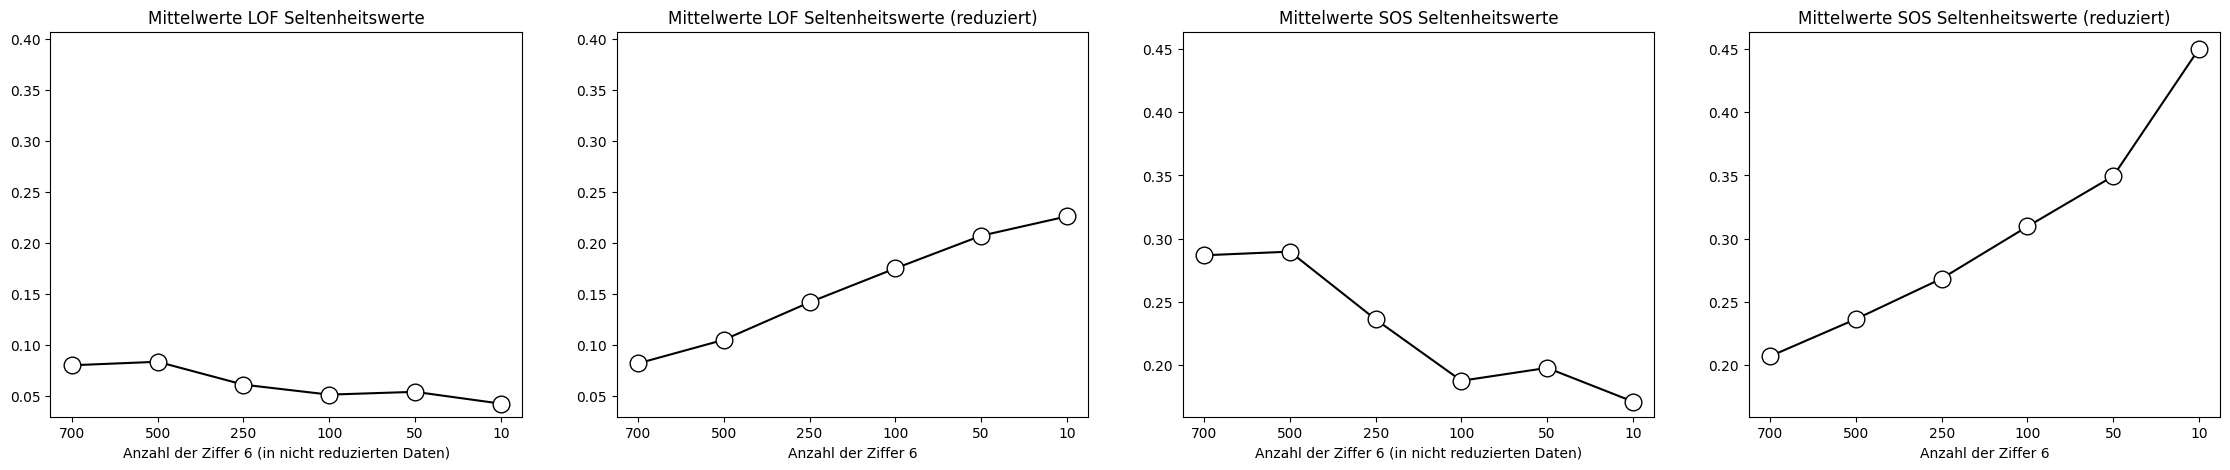

In [503]:
fig, axs = plt.subplots(1, 4, figsize=(28, 5))

axs[0].plot(rarity_scores_lof_means , color='black', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte LOF Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit_6)))
axs[0].set_xticklabels(examples_per_digit_6)
axs[0].set_xlabel('Anzahl der Ziffer 6 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_lof_means)*0.70, max(rarity_scores_red_lof_means)*1.8])

axs[1].plot(rarity_scores_red_lof_means , color='black', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte LOF Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit_6)))
axs[1].set_xticklabels(examples_per_digit_6)
axs[1].set_xlabel('Anzahl der Ziffer 6')
axs[1].set_ylim([min(rarity_scores_lof_means)*0.70, max(rarity_scores_red_lof_means)*1.8])

axs[2].plot(rarity_scores_sos_means , color='black', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte SOS Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit_6)))
axs[2].set_xticklabels(examples_per_digit_6)
axs[2].set_xlabel('Anzahl der Ziffer 6 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_sos_means)*0.93, max(rarity_scores_red_sos_means)*1.03])

axs[3].plot(rarity_scores_red_sos_means , color='black', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte SOS Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit_6)))
axs[3].set_xticklabels(examples_per_digit_6)
axs[3].set_xlabel('Anzahl der Ziffer 6')
axs[3].set_ylim([min(rarity_scores_sos_means)*0.93, max(rarity_scores_red_sos_means)*1.03])

## Multi Test: Reduziere Ziffer 0

In [504]:
 # Funktion, um verschiedene Arten von Seltenheitswerten zu berechnen
def calculate_rarity_scores(audio_files_reduced, distances, n_neighbours=200):
    # Erstelle eine neue Distanzmatrix, die nur die kombinierten Dateien berücksichtigt
    reduced_indices = [audio_files.index(file) for file in audio_files_reduced]
    distances_red = distances[np.ix_(reduced_indices, reduced_indices)]

    # N-Mean Methode
    sorted_scores = [sorted(score_array)[:n_neighbours] for score_array in distances_red]
    value_sums = [sum(score_array) for score_array in sorted_scores]
    instance_counts = [len(score_array) for score_array in sorted_scores]
    averages = [value_sum / instance_count for value_sum, instance_count in zip(value_sums, instance_counts)]

    # Normalisierung und Umkehrung
    rarityScore = averages
    min_score = min(rarityScore)
    max_score = max(rarityScore)
    rarityScore = (rarityScore - min_score) / (max_score - min_score)
    
    # Flussbasierte Seltenheitswerte
    scores_normalized = (distances_red - distances_red.min()) / (distances_red.max() - distances_red.min())
    sorted_ids = np.argsort(scores_normalized)
    n_next_hubs = n_neighbours
    inward_flow_results = np.zeros(len(scores_normalized))
    
    for id in range(len(scores_normalized)):
        idx = sorted_ids[id][1:(n_next_hubs + 1)]
        inward_flow_results[id] += np.exp(-10 * scores_normalized[id, idx]).sum()
    
    rarityScore_flow_red = 1 - inward_flow_results
    rarityScore_flow_red = (rarityScore_flow_red - np.min(rarityScore_flow_red)) / (np.max(rarityScore_flow_red) - np.min(rarityScore_flow_red))
    
    # LOF
    lof = LOF(n_neighbors=n_neighbours, novelty=True, metric='cosine')
    lof.fit(distances_red)
    rarity_score_lof = lof.decision_function(distances_red)
    rarity_score_lof = (rarity_score_lof - np.min(rarity_score_lof)) / (np.max(rarity_score_lof) - np.min(rarity_score_lof))

    # SOS
    sos = SOS(metric='euclidean', perplexity=n_neighbours)
    sos.fit(distances_red)
    outlier_scores_sos = sos.decision_function(distances_red)
    rarity_score_sos = (outlier_scores_sos - np.min(outlier_scores_sos)) / (np.max(outlier_scores_sos) - np.min(outlier_scores_sos))

    # Sampling
    sp = Sampling(subset_size=n_neighbours, contamination=0.1, metric='euclidean')
    sp.fit(distances_red)
    outlier_scores_sp = sp.decision_function(distances_red)
    rarity_score_sp = (outlier_scores_sp - np.min(outlier_scores_sp)) / (np.max(outlier_scores_sp) - np.min(outlier_scores_sp))

    # Rückgabe aller fünf Seltenheitswertarten
    return rarityScore, rarityScore_flow_red, rarity_score_lof, rarity_score_sos, rarity_score_sp, reduced_indices

# Hauptfunktion zur Reduzierung und Berechnung der Seltenheitswerte
def reduce_and_calculate_rarity_for_digit_two(examples_per_digit_0, audio_files, distances, extracted_numbers):
    # Initialisiere Listen für jeden Seltenheitswerttyp und für reduzierte Dateien und Indizes
    rarity_scores_reduced0 = []
    rarity_scores_reduced0_flow = []
    rarity_scores_reduced0_lof = []
    rarity_scores_reduced0_sos = []
    rarity_scores_reduced0_sp = []
    reduced_indices_list = []  # Liste für reduced_indices

    for max_files in examples_per_digit_0:
        # Selektiere Dateien für die Ziffer 0 bis zum gewünschten Limit
        label_0_files = [file for file, label in zip(audio_files, extracted_numbers) if label == 0][:max_files]
        # Behalte alle Dateien, die nicht zur Ziffer 2 gehören
        non_label_0_files = [file for file, label in zip(audio_files, extracted_numbers) if label != 0]
        # Kombiniere die Dateilisten
        combined_files = label_0_files + non_label_0_files

        # Liste für die extrahierten Zahlen
        extracted_numbers_red0 = []

        # Anstatt die Scores direkt in die Hauptliste einzufügen, fügen Sie sie zu den spezifischen Listen hinzu
        for scores, flow_scores, lof_scores, sos_scores, sp_scores, _ in [calculate_rarity_scores(combined_files, distances)]:
            rarity_scores_reduced0.append(scores)
            rarity_scores_reduced0_flow.append(flow_scores)
            rarity_scores_reduced0_lof.append(lof_scores)
            rarity_scores_reduced0_sos.append(sos_scores)
            rarity_scores_reduced0_sp.append(sp_scores)
            reduced_indices_list.append(reduced_indices)

            for file in combined_files:
                # Trenne den Dateinamen an den Unterstrichen
                parts = file.split('_')
                # Extrahiere die erste Zahl (als String) und konvertiere sie in ein Integer
                number = int(parts[0].split('/')[-1])
                # Füge die Zahl zur Liste hininzu
                extracted_numbers_red0.append(number)

    # Rückgabe der organisierten Listen mit Seltenheitswerten sowie der Listen reduzierter Dateien und Indizes
    return rarity_scores_reduced0, rarity_scores_reduced0_flow, rarity_scores_reduced0_lof, rarity_scores_reduced0_sos, rarity_scores_reduced0_sp, reduced_indices_list, extracted_numbers_red0

# Anzahl der Beispiele, die für die Ziffer 2 reduziert werden sollen
examples_per_digit_0 = [700, 500, 250, 100, 50, 10]

# Aufruf der Hauptfunktion und Organisieren der Ergebnisse entsprechend
rarity_scores_reduced0, rarity_scores_reduced0_flow, rarity_scores_reduced0_lof, rarity_scores_reduced0_sos, rarity_scores_reduced0_sp, reduced_indices_list, extracted_numbers_red0 = reduce_and_calculate_rarity_for_digit_two(examples_per_digit_0, audio_files, distances, extracted_numbers)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/extmath.py:192: RuntimeWar

In [505]:
for i, scores in enumerate(rarity_scores_reduced0):
    rarity_scores_reduced0[i] = np.array(rarity_scores_reduced0[i])
    rarity_scores_reduced0_flow[i] = np.array(rarity_scores_reduced0_flow[i])
    rarity_scores_reduced0_lof[i] = np.array(rarity_scores_reduced0_lof[i])
    rarity_scores_reduced0_sos[i] = np.array(rarity_scores_reduced0_sos[i])
    rarity_scores_reduced0_sp[i] = np.array(rarity_scores_reduced0_sp[i])

In [506]:
# Labels definieren
labels = extracted_numbers


rarity_scores_means = []
rarity_scores_red_means = []
rarity_scores_flow_means = []
rarity_scores_red_flow_means = []
rarity_scores_lof_means = []
rarity_scores_red_lof_means = []
rarity_scores_sos_means = []
rarity_scores_red_sos_means = []
rarity_scores_sp_means = []
rarity_scores_red_sp_means = []


# Mittelwert Loop
for i, (scores, scores_flow, scores_lof, scores_sos, scores_sp) in enumerate(zip(rarity_scores_reduced0, rarity_scores_reduced0_flow, rarity_scores_reduced0_lof, rarity_scores_reduced0_sos, rarity_scores_reduced0_sp)):
    if i < 6:
        labels_reduced = extracted_numbers_red0[i]
        filtered_indices = [index for index, value in enumerate(extracted_numbers) if value == 0]
        filtered_indices_red = [index for index, value in enumerate(extracted_numbers_red0) if value == 0]
        filtered_numbers = [examples_per_digit_0[i]]

        # Filtern der Daten
        filtered_rarity_score = rarityScore[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red = scores[filtered_indices_red]

        filtered_rarity_score_flow = rarityScore_flow[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red_flow = scores_flow[filtered_indices_red]
        
        filtered_rarity_score_lof = rarity_score_lof[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red_lof = scores_lof[filtered_indices_red]
            
        filtered_rarity_score_sos = rarity_score_sos[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red_sos = scores_sos[filtered_indices_red]

        filtered_rarity_score_sp = rarity_score_sp[filtered_indices[:filtered_numbers[0]]]
        filtered_rarity_score_red_sp = scores_sp[filtered_indices_red]

        # Berechne Mittelwert
        rarity_scores_means.append(filtered_rarity_score.mean())
        rarity_scores_red_means.append(filtered_rarity_score_red.mean())

        rarity_scores_flow_means.append(filtered_rarity_score_flow.mean())
        rarity_scores_red_flow_means.append(filtered_rarity_score_red_flow.mean())

        rarity_scores_lof_means.append(filtered_rarity_score_lof.mean())
        rarity_scores_red_lof_means.append(filtered_rarity_score_red_lof.mean())

        rarity_scores_sos_means.append(filtered_rarity_score_sos.mean())
        rarity_scores_red_sos_means.append(filtered_rarity_score_red_sos.mean())

        rarity_scores_sp_means.append(filtered_rarity_score_sp.mean())
        rarity_scores_red_sp_means.append(filtered_rarity_score_red_sp.mean())

print(rarity_scores_means, '\n ', rarity_scores_red_means ,'\n ' ,rarity_scores_flow_means , '\n ', rarity_scores_red_flow_means, '\n ' ,rarity_scores_lof_means , '\n ', rarity_scores_red_lof_means, '\n ' ,rarity_scores_sos_means , '\n ', rarity_scores_red_sos_means, '\n ' ,rarity_scores_sp_means , '\n ', rarity_scores_red_sp_means)



[0.15258676112420824, 0.15180742814980736, 0.1077321919032705, 0.15420512303681572, 0.1472893884080507, 0.14939483042983748] 
  [0.15569451305438214, 0.16533440849700176, 0.16826365652283296, 0.1715337191077184, 0.17378202301973888, 0.17874538496468795] 
  [0.39245089644953063, 0.3848931095767805, 0.3157119199748331, 0.41884116059871396, 0.4181959716243236, 0.4235203332846179] 
  [0.4395388834878444, 0.45920120542859755, 0.46710585707066093, 0.4745445694740932, 0.47996614382908087, 0.49184768758035935] 
  [0.029771549995053888, 0.03420780609218791, 0.017173687028412935, 0.021814511718435403, 0.027699912928681264, 0.028010090300310358] 
  [0.026793441536864825, 0.02728924707121024, 0.026656116675143844, 0.02515111807449664, 0.02483254870235937, 0.024764586775187475] 
  [0.1696105528382226, 0.18102118947409485, 0.14399657806771518, 0.13946024731629872, 0.17433647441448477, 0.19823581116195127] 
  [0.19031295083873093, 0.18401075441014286, 0.19136521253889588, 0.17229169167256203, 0.16855

(0.3093976815753364, 0.5066031182077702)

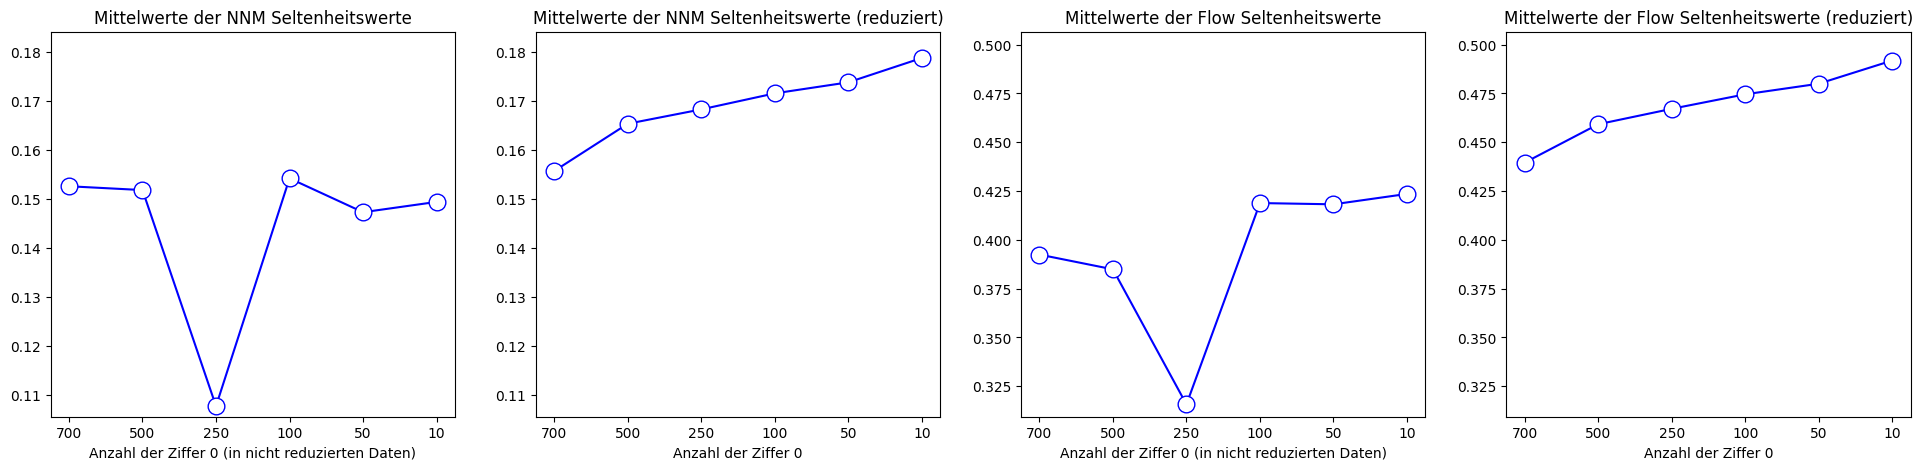

In [507]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

axs[0].plot(rarity_scores_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte der NNM Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit_0)))
axs[0].set_xticklabels(examples_per_digit_0)
axs[0].set_xlabel('Anzahl der Ziffer 0 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_means)*0.98, max(rarity_scores_red_means)*1.03])

axs[1].plot(rarity_scores_red_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte der NNM Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit_0)))
axs[1].set_xticklabels(examples_per_digit_0)
axs[1].set_xlabel('Anzahl der Ziffer 0')
axs[1].set_ylim([min(rarity_scores_means)*0.98, max(rarity_scores_red_means)*1.03])

axs[2].plot(rarity_scores_flow_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte der Flow Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit_0)))
axs[2].set_xticklabels(examples_per_digit_0)
axs[2].set_xlabel('Anzahl der Ziffer 0 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_flow_means)*0.98, max(rarity_scores_red_flow_means)*1.03])

axs[3].plot(rarity_scores_red_flow_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte der Flow Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit_0)))
axs[3].set_xticklabels(examples_per_digit_0)
axs[3].set_xlabel('Anzahl der Ziffer 0')
axs[3].set_ylim([min(rarity_scores_flow_means)*0.98, max(rarity_scores_red_flow_means)*1.03])

(0.1296980300041578, 0.2047607774166186)

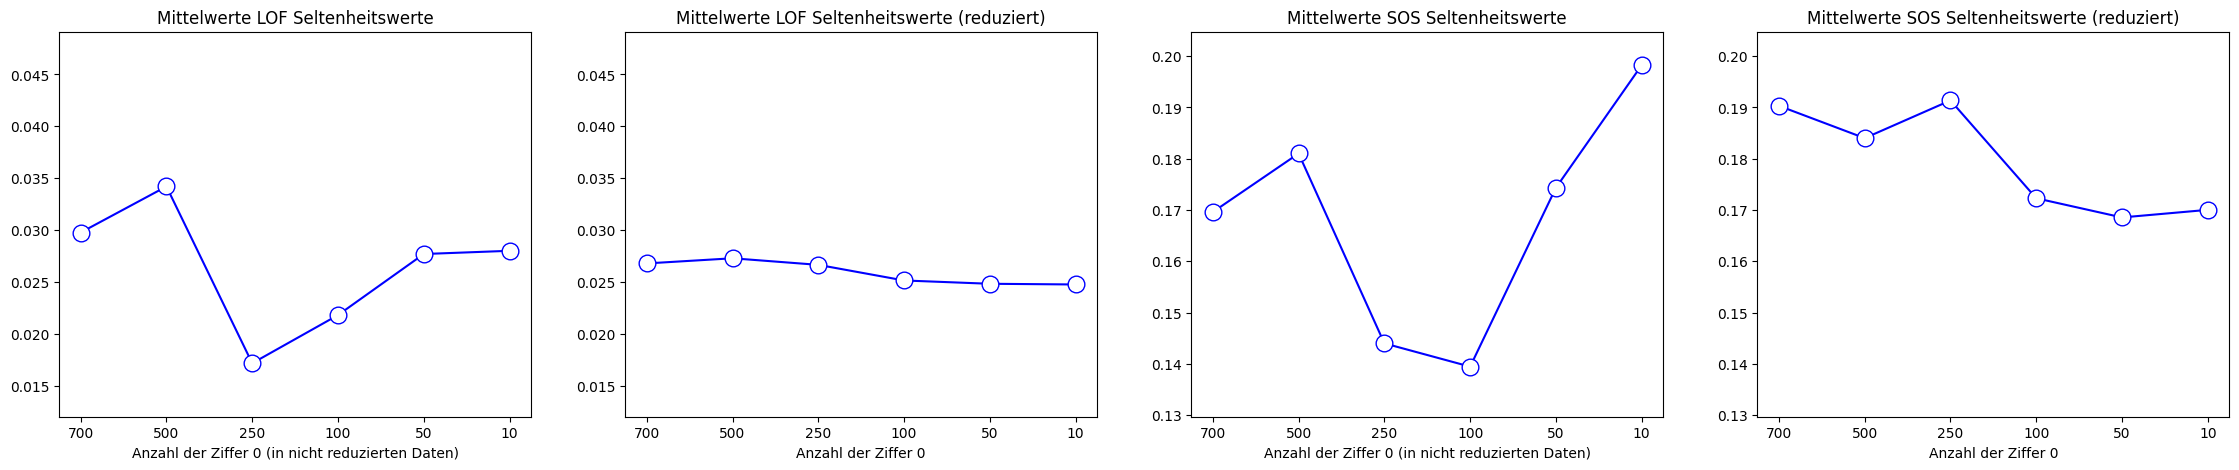

In [508]:
fig, axs = plt.subplots(1, 4, figsize=(28, 5))

axs[0].plot(rarity_scores_lof_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[0].set_title('Mittelwerte LOF Seltenheitswerte')
axs[0].set_xticks(range(len(examples_per_digit_0)))
axs[0].set_xticklabels(examples_per_digit_0)
axs[0].set_xlabel('Anzahl der Ziffer 0 (in nicht reduzierten Daten)')
axs[0].set_ylim([min(rarity_scores_lof_means)*0.70, max(rarity_scores_red_lof_means)*1.8])

axs[1].plot(rarity_scores_red_lof_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[1].set_title('Mittelwerte LOF Seltenheitswerte (reduziert)')
axs[1].set_xticks(range(len(examples_per_digit_0)))
axs[1].set_xticklabels(examples_per_digit_0)
axs[1].set_xlabel('Anzahl der Ziffer 0')
axs[1].set_ylim([min(rarity_scores_lof_means)*0.70, max(rarity_scores_red_lof_means)*1.8])

axs[2].plot(rarity_scores_sos_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[2].set_title('Mittelwerte SOS Seltenheitswerte')
axs[2].set_xticks(range(len(examples_per_digit_0)))
axs[2].set_xticklabels(examples_per_digit_0)
axs[2].set_xlabel('Anzahl der Ziffer 0 (in nicht reduzierten Daten)')
axs[2].set_ylim([min(rarity_scores_sos_means)*0.93, max(rarity_scores_red_sos_means)*1.07])

axs[3].plot(rarity_scores_red_sos_means , color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
axs[3].set_title('Mittelwerte SOS Seltenheitswerte (reduziert)')
axs[3].set_xticks(range(len(examples_per_digit_0)))
axs[3].set_xticklabels(examples_per_digit_0)
axs[3].set_xlabel('Anzahl der Ziffer 0')
axs[3].set_ylim([min(rarity_scores_sos_means)*0.93, max(rarity_scores_red_sos_means)*1.07])